In [ ]:
!pip install einops
!sudo aptitude install texlive-fonts-recommended texlive-fonts-extra
!sudo apt-get install dvipng

In [2]:
!mkdir CelebA && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

--2024-06-18 20:08:40--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.192.64, 52.219.193.112, 52.219.120.168, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.192.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  62.5MB/s    in 22s     

2024-06-18 20:09:03 (62.5 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [3]:
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("CelebA/")

In [21]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models


import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from einops import rearrange

# from latex import latexify
# latexify(columns = 2)

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


## Forward Process

$$ \textbf{x}_t = \sqrt{1 - \beta_t} \textbf{x}_{t - 1} + \sqrt{\beta_t} \epsilon_{t - 1} $$

$$ \boxed{\textbf{x}_t = \sqrt{\bar{\alpha_t}} \textbf{x}_0 + \sqrt{1 - \bar{\alpha_t}} \epsilon} $$

$$ \boxed{q(\textbf{x}_t | \textbf{x}_0) = \mathcal{N}(\textbf{x}_t; \sqrt{\bar{\alpha_t}} \textbf{x}_0, (1 - \bar{\alpha_t}) \mathbb{I})} $$

## Reverse Distribution

$$ \boxed{q(\textbf{x}_{t - 1} | \textbf{x}_t, \textbf{x}_0) = \mathcal{N}(\textbf{x}_{t - 1}; \boldsymbol{\mu}_q(\textbf{x}_0, \textbf{x}_t), \mathbf{\Sigma}_q(t))} $$

$$ \boxed{\boldsymbol{\mu}_q(\textbf{x}_t, \textbf{x}_0) = \frac{(1 - \bar{\alpha}_{t - 1}) \sqrt{\alpha_t}}{1 - \bar{\alpha}_t} \textbf{x}_t + \frac{(1 - \alpha_t)\sqrt{\bar{\alpha}_{t - 1}}}{1 - \bar{\alpha}_t}\textbf{x}_0} $$

$$ \boxed{\boldsymbol{\mu}_q(t) = \frac{1}{\sqrt{\alpha_t}} \left(\textbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_t \right)} $$

## Loss Function

$$ L_{VN} = \sum_{t = 2}^T D_{KL} \left(p_{\theta}(\textbf{x}_{t - 1} | \textbf{x}_t) \parallel q(\textbf{x}_{t - 1} | \textbf{x}_t, \textbf{x}_0) \right) + \log p_{\theta}(\textbf{x}_0 | \textbf{x}_1) $$

$$ p_{\theta}(\textbf{x}_{t - 1} | \textbf{x}_t) = \mathcal{N}(\textbf{x}_{t - 1}; \boldsymbol{\mu}_{\theta}(\textbf{x}_t, t), \mathbf{\Sigma}_{\theta}(\textbf{x}_t, t)) $$

$$ L_t = \mathbb{E}_{\textbf{x}_0, \boldsymbol{\epsilon}} \left[ \frac{1}{2 \lVert \mathbf{\Sigma}_{\theta}(\textbf{x}_t, t) \rVert^2_2} \lVert \boldsymbol{\mu}_{\theta}(\textbf{x}_t, t) - \boldsymbol{\mu}_t(\textbf{x}_t, \textbf{x}_0) \rVert^2 \right] $$

$$ \boldsymbol{\mu}_{\theta}(\textbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left(\textbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_{\theta}(\textbf{x}_t, t) \right) $$

$$ L_t = \mathbb{E}_{\textbf{x}_0, \boldsymbol{\epsilon}} \left[ \frac{(1 - \alpha_t)^2}{2 \alpha_t (1 - \bar{\alpha}_t) \lVert \mathbf{\Sigma}_{\theta} \rVert^2_2} \lVert \boldsymbol{\epsilon}_{\theta}(\textbf{x}_t, t) - \boldsymbol{\epsilon}_t \rVert^2 \right] $$

$$ \color{OrangeRed}{\boxed{L_t^{\text{Simple}} = \mathbb{E}_{t \sim [1, T], \textbf{x}_0, \boldsymbol{\epsilon}_t} \left[\lVert \boldsymbol{\epsilon}_{\theta}((\sqrt{\bar{\alpha_t}}) \textbf{x}_0 + (\sqrt{1 - \bar{\alpha_t}})\boldsymbol{\epsilon}_t , t) - \boldsymbol{\epsilon}_t \rVert^2 \right]}} $$

<p align="center">
<img src="./Media/DiffAlgo.png" style="width:70%;border:0;">
</p>

## Noise Scheduler

### **Task1:** Getting the noisy image given $\textbf{x}_t, t, \epsilon$
$$ \textbf{x}_t, t, \epsilon \to \textbf{x}_t = \sqrt{\bar{\alpha_t}} \textbf{x}_0 + \sqrt{1 - \bar{\alpha_t}} \epsilon $$

$$ \alpha_t = 1 - \beta_t $$

$$ \bar{\alpha}_t = \prod_{i = 1}^t \alpha_i $$

We use linear noise scheduler with $\beta_1 = 10^{-4}$ to $\beta_T = 0.02$ and $T = 1000$ steps between them.

### **Task2:** Given $\textbf{x}_t$ get $\textbf{x}_{t - 1}$

$$ p_{\theta}(\textbf{x}_{t - 1} | \textbf{x}_t) = \mathcal{N}(\textbf{x}_{t - 1}; \boldsymbol{\mu}_{\theta}(\textbf{x}_t, t), \mathbf{\Sigma}_{\theta}(\textbf{x}_t, t)) $$

$$ \boldsymbol{\mu}_{\theta} = \frac{1}{\sqrt{\alpha_t}} \left(\textbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_{\theta} \right) $$

$$ \Sigma_q(t) = \frac{(1 - \alpha_t) \cdot (1 - \bar{\alpha}_{t - 1})}{(1 - \bar{\alpha}_t)} \mathbb{I} $$

$$
\begin{align}
\textbf{x}_{t - 1} = \boldsymbol{\mu}_{\theta} + \sigma_t \textbf{z} && \textbf{z} \sim \mathcal{N}(\textbf{0}, \mathbb{I})
\end{align}
$$



In [5]:
class LinearNoiseScheduler:
    def __init__(self, T, beta_start, beta_end):
        self.T = T
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.betas = torch.linspace(beta_start, beta_end, T)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim = 0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_1m_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)

    def add_noise(self, original, noise, t):
        original_shape = original.shape
        batch_size = original_shape[0]

        sqrt_alpha_cum_prod = self.sqrt_alphas_cumprod.to(original.device)[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_1m_alphas_cumprod.to(original.device)[t].reshape(batch_size)

        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
        for _ in range(len(original_shape) - 1):
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        return (sqrt_alpha_cum_prod.to(original.device) * original
                + sqrt_one_minus_alpha_cum_prod.to(original.device) * noise)

    def sample_prev_timestep(self, xt, noise_pred, t):
        x0 = (xt - (self.sqrt_alphas_cumprod.to(xt.device)[t] * noise_pred)) / self.sqrt_alphas_cumprod.to(xt.device)[t]
        x0 = torch.clamp(x0, -1., 1.)

        mean = (xt - ((self.betas.to(xt.device)[t] * noise_pred) / (self.sqrt_1m_alphas_cumprod.to(xt.device)[t]))) / torch.sqrt(self.alphas.to(xt.device)[t])

        if t == 0:
            return mean, x0
        else:
            variance = ((1 - self.alphas_cumprod.to(xt.device)[t - 1]) * self.betas.to(xt.device)[t]) / (1. - self.alphas_cumprod.to(xt.device)[t])
            sigma = variance ** 0.5
            z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma * z, x0

## Model Architecture - **UNet** inspired

<p align="center">
<img src="./Media/DiffModel.png" style="width:60%;border:0;">
</p>

<p align="center">
<img src="./Media/UNet.png" style="width:60%;border:0;">
</p>


$$ \text{DownBlock} \to \text{MidBlock} \to \text{UpBlock} $$

### **Time Embedding Block**

Positional Encoding for a position $t$ of an object, $d$ dimension of output embedding space, $i$ represents column index

<p align="center">
<img src="./Media/PocEnc.png" style="width:60%;border:0;">
</p>

$$ P(t, 2i) = \sin \left( \frac{t}{10000^{2i/d_{\text{model}}}} \right) $$
$$ P(t, 2i + 1) = \cos \left( \frac{t}{10000^{2i/d_{\text{model}}}} \right) $$

**Positional Encoding Block** $\to$ **FC Layer** $\to$ **$\text{SiLU}$ Activation** $\to$ **FC Layer**

In [6]:
def get_time_embedding(T, d_model):
    factor = 10000 ** ((torch.arange(start = 0, end = d_model // 2, dtype = torch.float32, device = T.device)) / (d_model // 2))
    t_emb = T[:, None].repeat(1, d_model // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim = -1)
    return t_emb

### **DownBlock of UNet**
There can be **multiple layers** of this $\text{ResNet} + \text{Self Attention}$
<p align="center">
<img src="./Media/UNetDown.png" style="width:60%;border:0;" alt = "image">
</p>

<p align="center">
<img src="./Media/UNetComp.png" style="width:60%;border:0;" alt = "image">
</p>

In [7]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, d_model, down_sample, num_heads):
        super().__init__()
        self.down_sample = down_sample
        self.resnet_conv_first = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
        )

        self.t_emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(d_model, out_channels)
        )

        self.resnet_conv_second = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
        )

        self.attention_norm = nn.GroupNorm(8, out_channels)
        self.attention = nn.MultiheadAttention(out_channels, num_heads, batch_first = True)
        self.residual_input_conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1)
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels, kernel_size = 4, stride = 2, padding = 1) if self.down_sample else nn.Identity()

    def forward(self, x, t_emb):
        out = x

        # ResNet Block
        resnet_input = out
        out = self.resnet_conv_first(out)
        out = out + self.t_emb_layers(t_emb)[:, :, None, None]
        out = self.resnet_conv_second(out)
        out = out + self.residual_input_conv(resnet_input)

        # Attention Block
        batch_size, channels, h, w = out.shape
        in_attn = out.reshape(batch_size, channels, h * w)
        in_attn = self.attention_norm(in_attn)
        in_attn = in_attn.transpose(1, 2)
        out_attn, _ = self.attention(in_attn, in_attn, in_attn)
        out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        out = out + out_attn

        out = self.down_sample_conv(out)
        return out


In [8]:
class MidBlock(nn.Module):
    def __init__(self, in_channels, out_channels, d_model, num_heads):
        super().__init__()
        self.resnet_conv_first = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8, in_channels),
                nn.SiLU(),
                nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
            ),
            nn.Sequential(
                nn.GroupNorm(8, out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
            )
        ])

        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(d_model, out_channels)
            ),
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(d_model, out_channels)
            )
        ])


        self.resnet_conv_second = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8, out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
            ),
            nn.Sequential(
                nn.GroupNorm(8, out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
            )
        ])

        self.attention_norm = nn.GroupNorm(8, out_channels)
        self.attention = nn.MultiheadAttention(out_channels, num_heads, batch_first = True)

        self.residual_input_conv = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size = 1),
            nn.Conv2d(out_channels, out_channels, kernel_size = 1)
        ])

    def forward(self, x, t_emb):
        out = x

        # First ResNet Block
        resnet_input = out
        out = self.resnet_conv_first[0](out)
        out = out + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)

        # Attention Block
        batch_size, channels, h, w = out.shape
        in_attn = out.reshape(batch_size, channels, h * w)
        in_attn = self.attention_norm(in_attn)
        in_attn = in_attn.transpose(1, 2)
        out_attn, _ = self.attention(in_attn, in_attn, in_attn)
        out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        out = out + out_attn

        # Second ResNet Block
        resnet_input = out
        out = self.resnet_conv_first[1](out)
        out = out + self.t_emb_layers[1](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[1](out)
        out = out + self.residual_input_conv[1](resnet_input)

        return out

In [9]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, d_model, up_sample, num_heads):
        super().__init__()
        self.up_sample = up_sample
        self.resnet_conv_first = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
        )

        self.t_emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(d_model, out_channels)
        )

        self.resnet_conv_second = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
        )

        self.attention_norm = nn.GroupNorm(8, out_channels)
        self.attention = nn.MultiheadAttention(out_channels, num_heads, batch_first = True)
        self.residual_input_conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1)
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()

    def forward(self, x, out_down, t_emb):
        x = self.up_sample_conv(x)

        # if x.shape[2:] != out_down.shape[2:]:
        #     x = F.interpolate(x, size=out_down.shape[2:], mode = "nearest")

        x = torch.cat([x, out_down], dim = 1)

        # ResNet Block
        out = x
        resnet_input = out
        out = self.resnet_conv_first(out)
        out = out + self.t_emb_layers(t_emb)[:, :, None, None]
        out = self.resnet_conv_second(out)
        out = out + self.residual_input_conv(resnet_input)

        # Attention Block
        batch_size, channels, h, w = out.shape
        in_attn = out.reshape(batch_size, channels, h * w)
        in_attn = self.attention_norm(in_attn)
        in_attn = in_attn.transpose(1, 2)
        out_attn, _ = self.attention(in_attn, in_attn, in_attn)
        out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        out = out + out_attn

        return out

In [10]:
class UNet(nn.Module):
    def __init__(self, im_channels):
        super().__init__()
        self.down_channels = [32, 64, 128, 256]
        self.mid_channels = [256, 256, 128]
        self.d_model = 128
        self.down_sample = [True, True, False]

        self.t_proj = nn.Sequential(
            nn.Linear(self.d_model, self.d_model),
            nn.SiLU(),
            nn.Linear(self.d_model, self.d_model)
        )

        self.up_sample = list(reversed(self.down_sample))
        self.conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size = 3, padding = (1, 1))

        self.downs = nn.ModuleList([])
        for i in range(len(self.down_channels) - 1):
            self.downs.append(DownBlock(self.down_channels[i], self.down_channels[i + 1], self.d_model, down_sample = self.down_sample[i], num_heads = 4))

        self.mids = nn.ModuleList([])
        for i in range(len(self.mid_channels) - 1):
            self.mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i + 1], self.d_model, num_heads = 4))

        self.ups = nn.ModuleList([])
        for i in reversed(range(len(self.down_channels) - 1)):
            self.ups.append(UpBlock(self.down_channels[i] * 2, self.down_channels[i - 1] if i != 0 else 16, self.d_model, up_sample = self.down_sample[i], num_heads = 4))

        self.norm_out = nn.GroupNorm(8, 16)
        self.conv_out = nn.Conv2d(16, im_channels, kernel_size = 3, padding = 1)


    def forward(self, x, t):
        out = self.conv_in(x)
        t_emb = self.t_proj(get_time_embedding(torch.as_tensor(t).long(), self.d_model))

        down_outs = []
        for down in self.downs:
            down_outs.append(out)
            out = down(out, t_emb)

        for mid in self.mids:
            out = mid(out, t_emb)

        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)

        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out)

        return out

In [12]:
# Train Parameters
batch_size = 64
num_epochs = 40
lr = 1e-4
num_grid_rows = 8
num_samples = 64

# Diffusion Parameters
beta_start = 1e-4
beta_end = 0.02
T = 1000

# Model Parameters
nc = 3
image_size = 32

In [13]:
transform = transforms.Compose([transforms.Resize(image_size), transforms.CenterCrop(image_size), transforms.ToTensor(), transforms.Normalize([0.5 for _ in range(nc)], [0.5 for _ in range(nc)])])

In [14]:
celebADataset = datasets.ImageFolder(root = "./CelebA", transform = transform)
celebALoader = DataLoader(dataset = celebADataset, batch_size = batch_size, shuffle = True)

In [15]:
scheduler = LinearNoiseScheduler(T, beta_start, beta_end)

model = UNet(nc).to(device)
model.train()

UNet(
  (t_proj): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (conv_in): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): DownBlock(
      (resnet_conv_first): Sequential(
        (0): GroupNorm(8, 32, eps=1e-05, affine=True)
        (1): SiLU()
        (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (t_emb_layers): Sequential(
        (0): SiLU()
        (1): Linear(in_features=128, out_features=64, bias=True)
      )
      (resnet_conv_second): Sequential(
        (0): GroupNorm(8, 64, eps=1e-05, affine=True)
        (1): SiLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (attention_norm): GroupNorm(8, 64, eps=1e-05, affine=True)
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_f

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    losses = []
    for i, (images, _) in enumerate(celebALoader):
        optimizer.zero_grad()
        images = images.float().to(device)

        noise = torch.randn_like(images).to(device)

        t = torch.randint(0, T, (images.shape[0],)).to(device)

        noisy_img = scheduler.add_noise(images, noise, t)
        noise_pred = model(noisy_img, t)

        loss = criterion(noise_pred, noise)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        del images
        del noisy_img
        del noise_pred
        del noise

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {np.mean(losses)}")
    torch.save(model.state_dict(), "denoiseModelCeleb.pth")

Epoch [1/40], Loss: 0.15396605083508275
Epoch [2/40], Loss: 0.044981116866687015


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 GiB. GPU 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

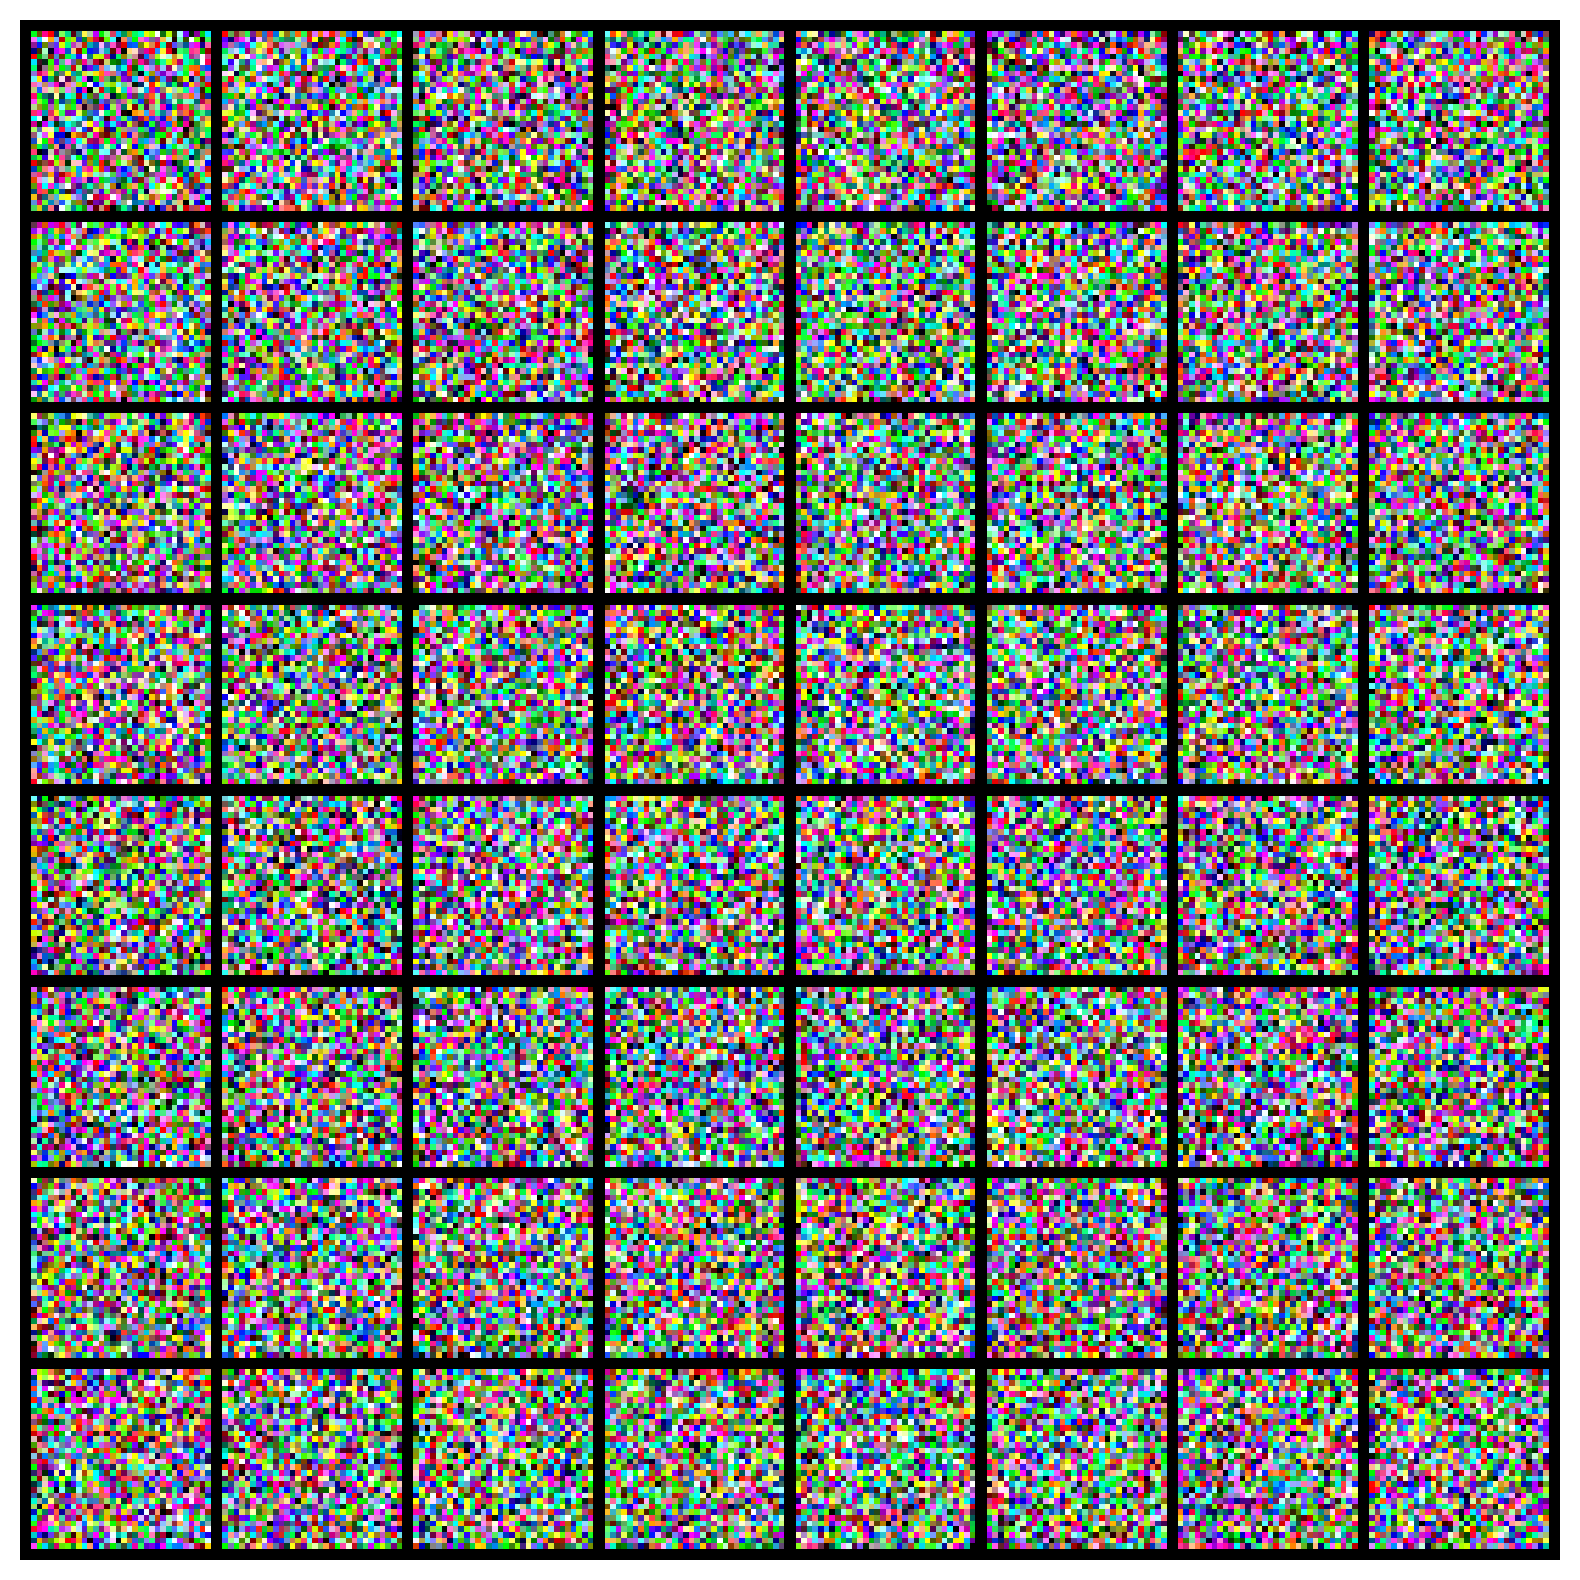

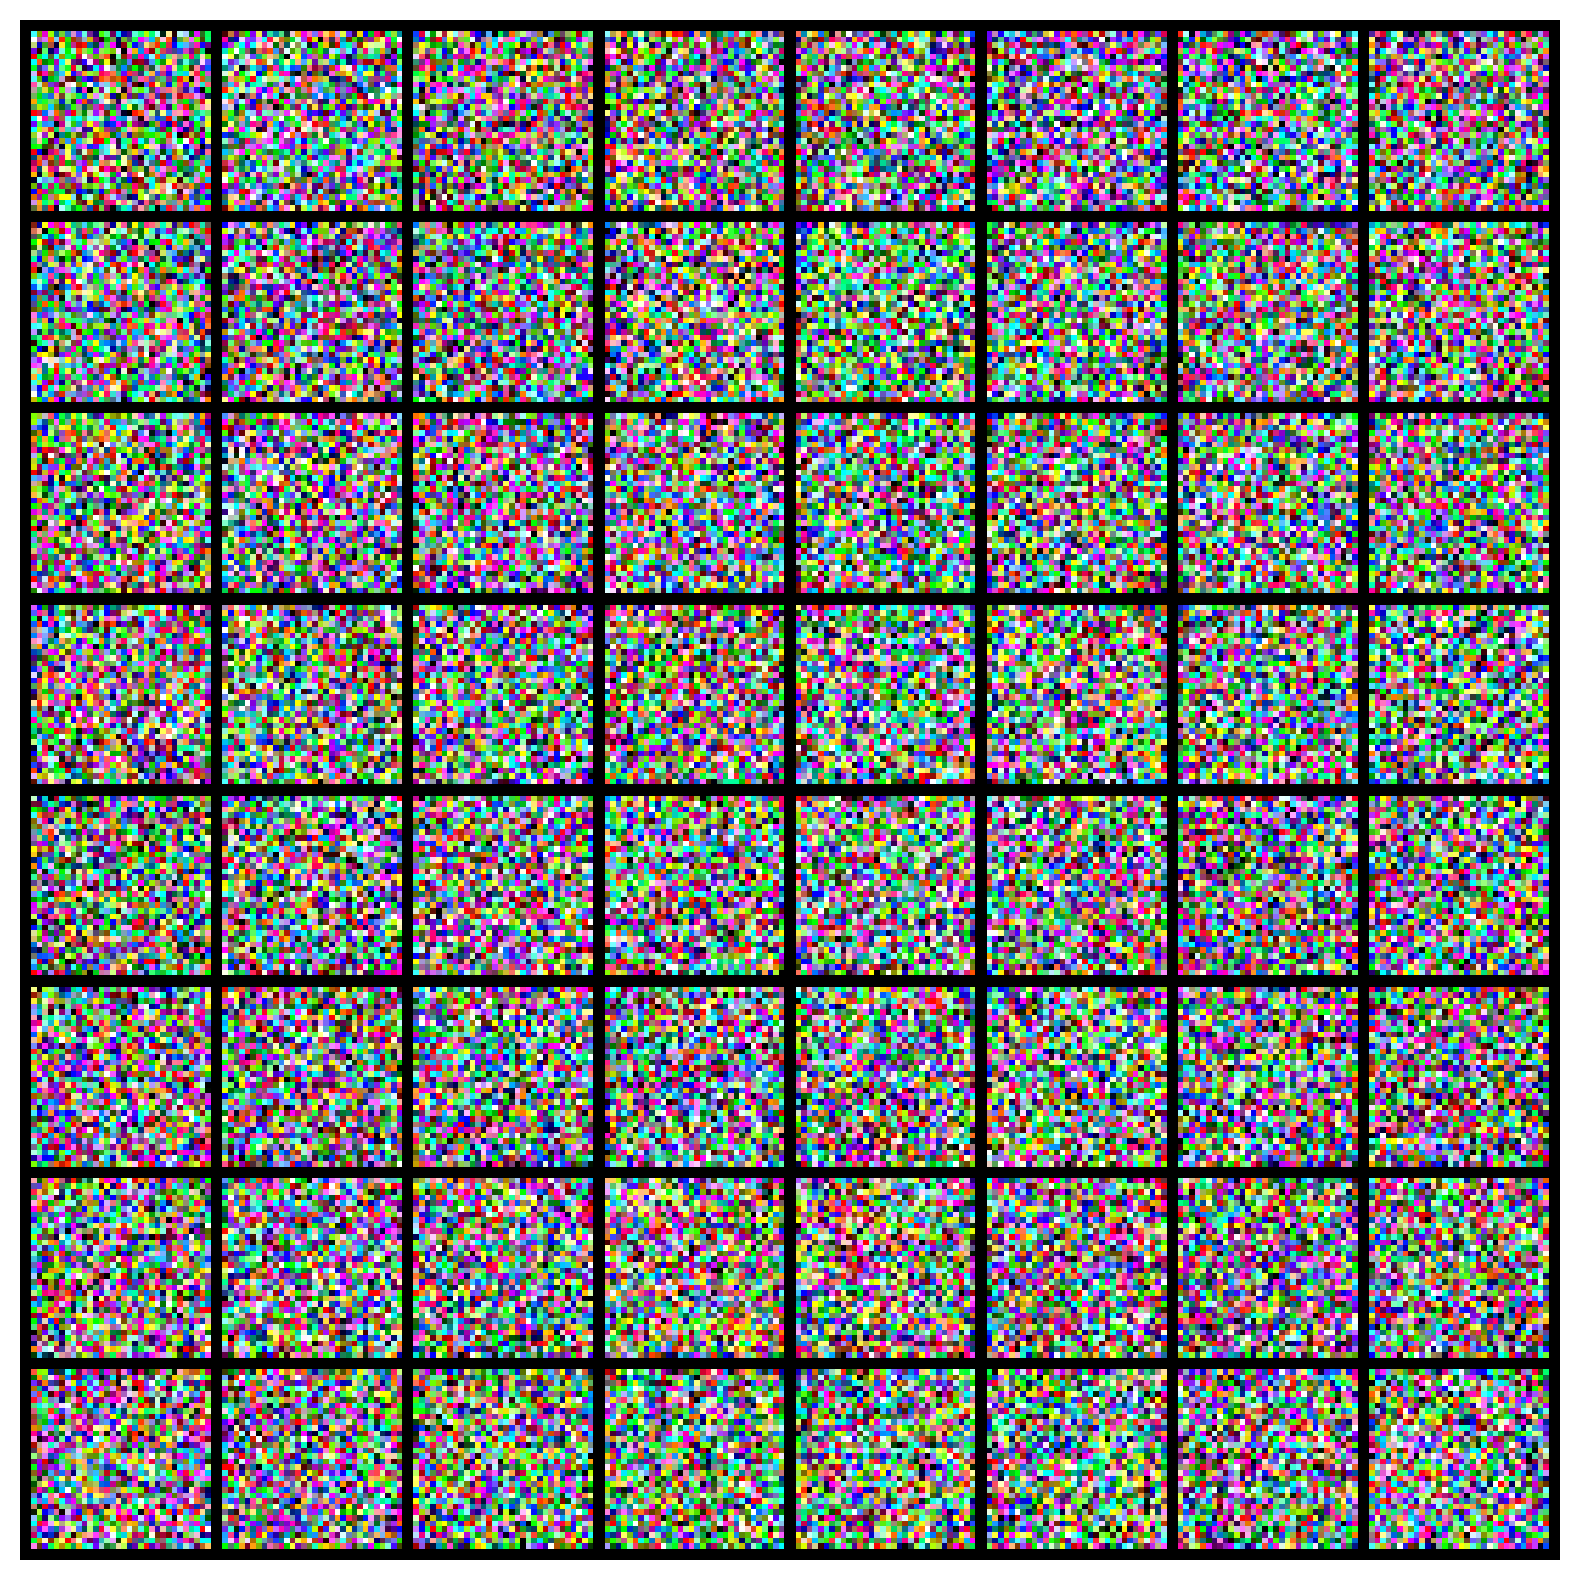

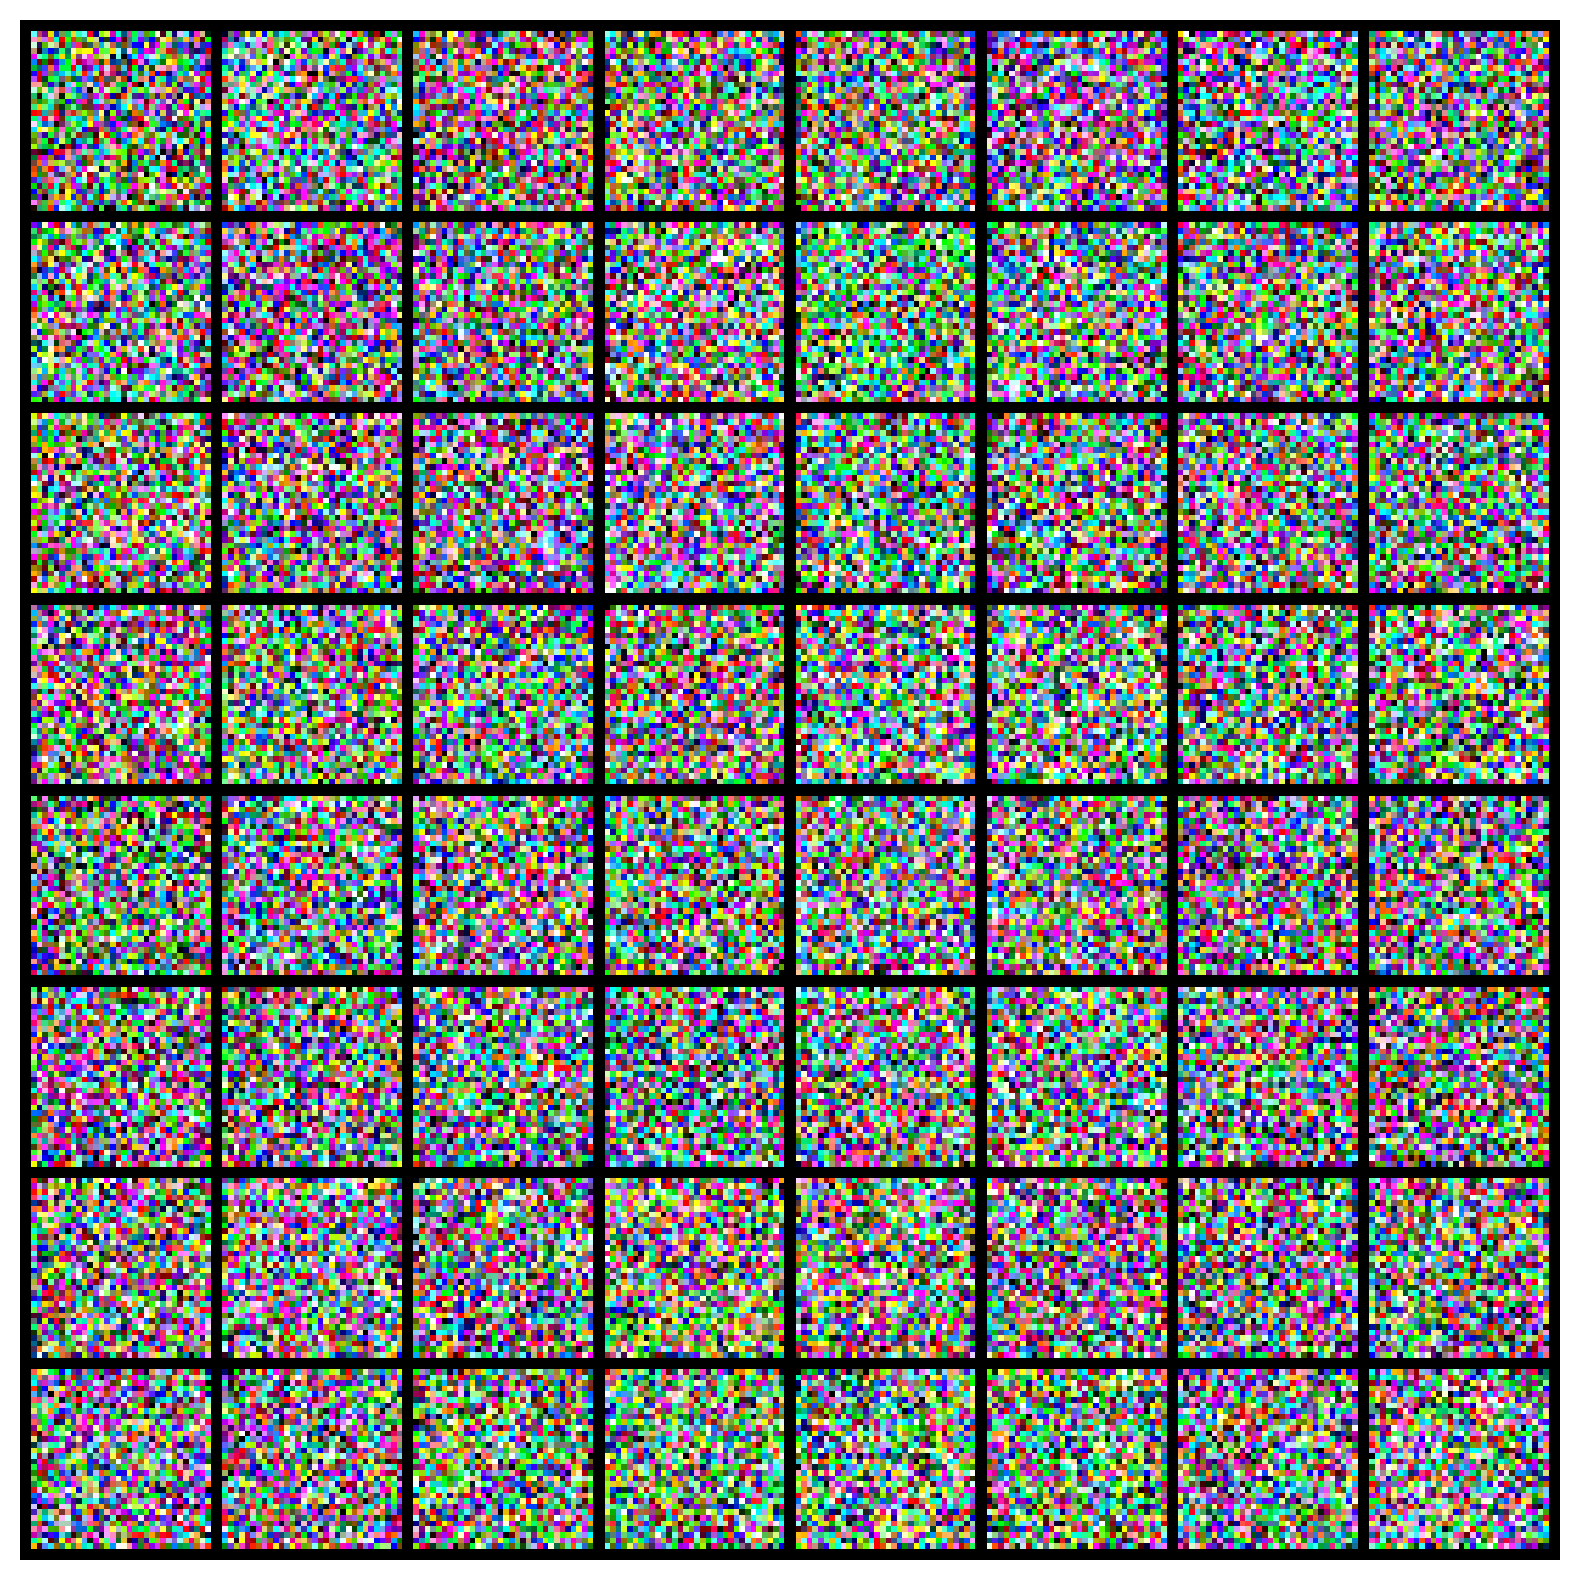

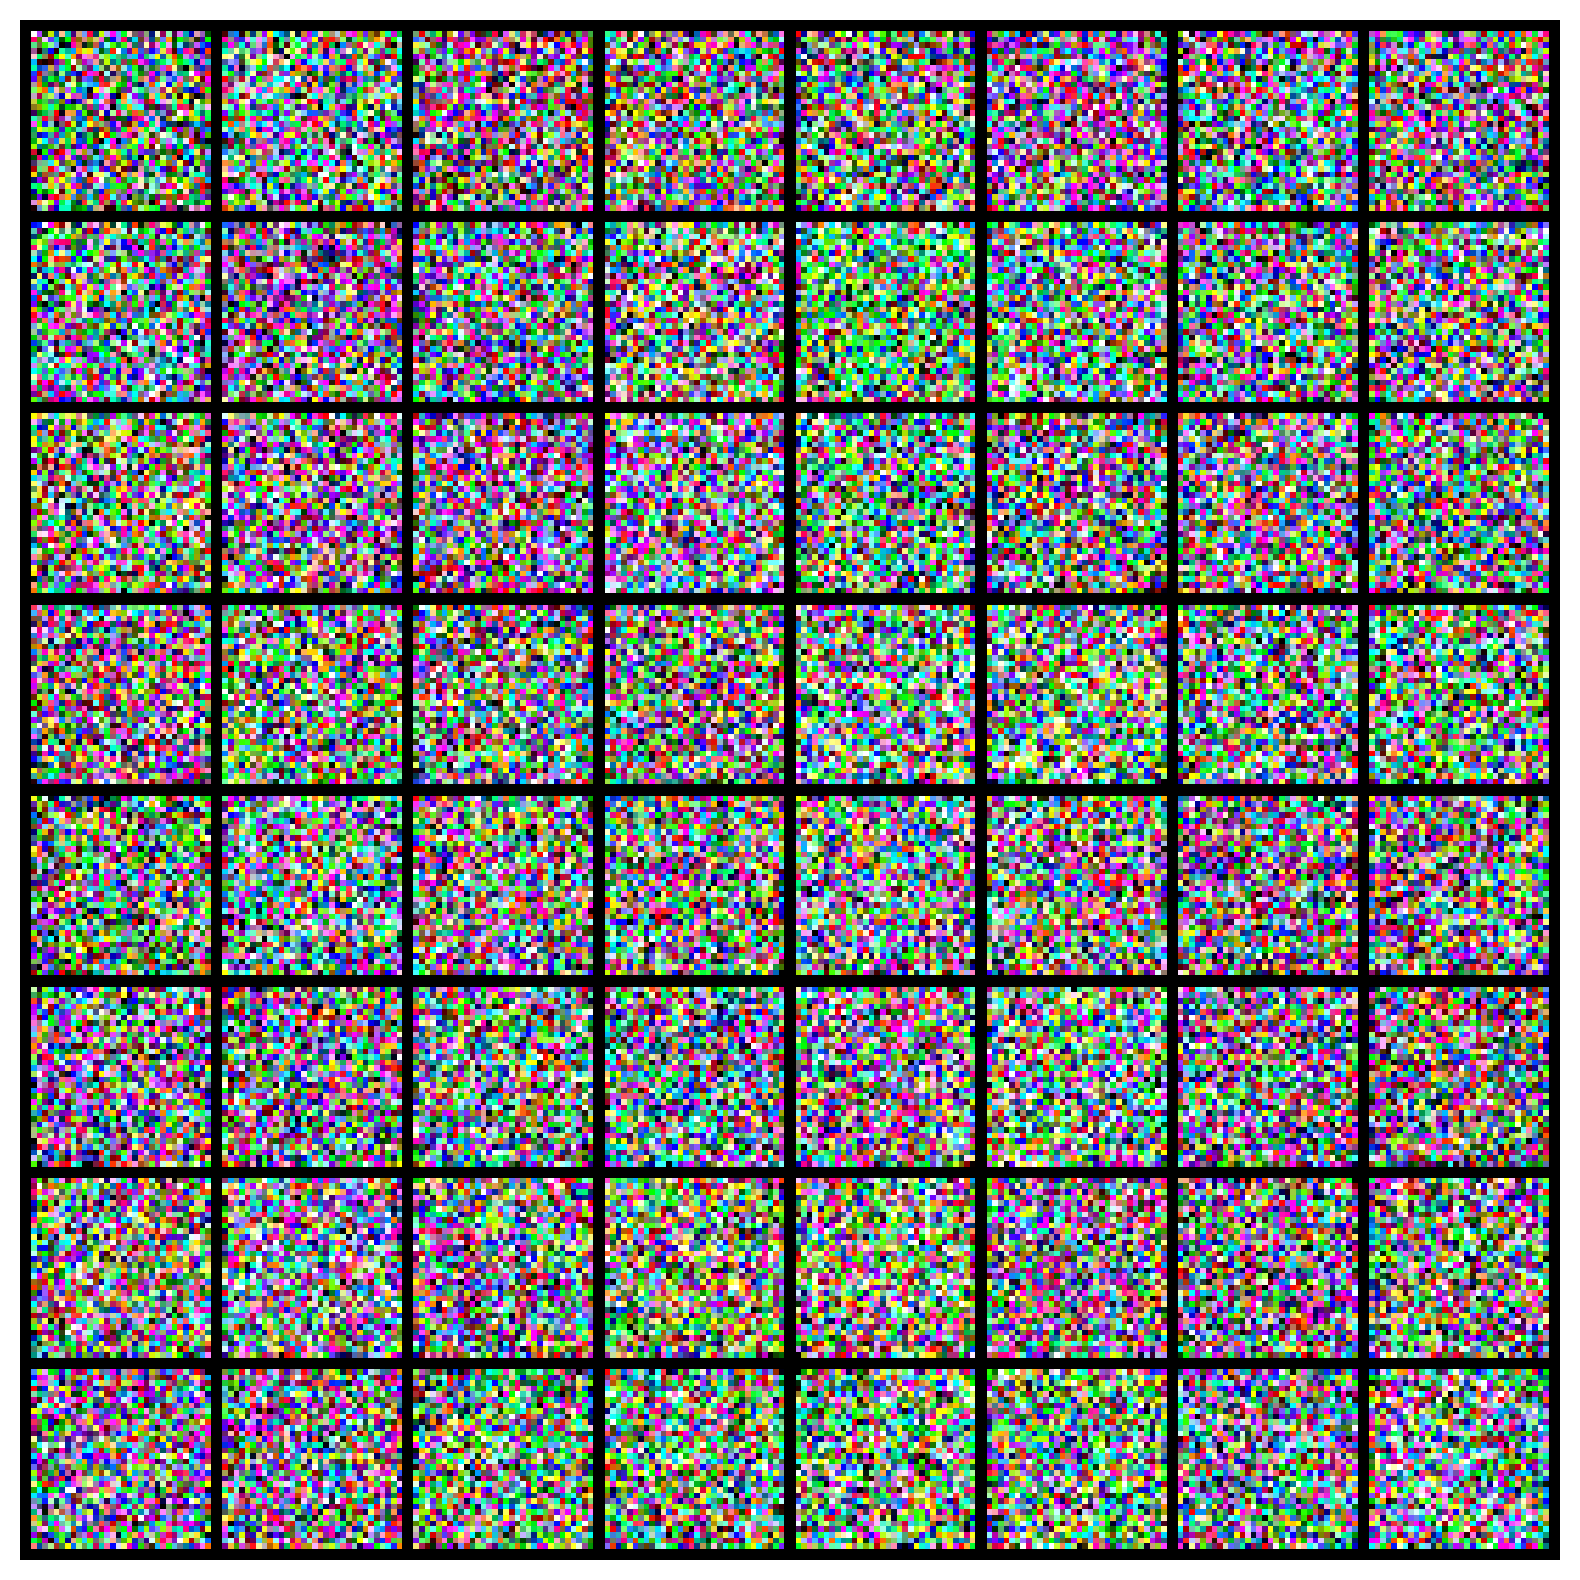

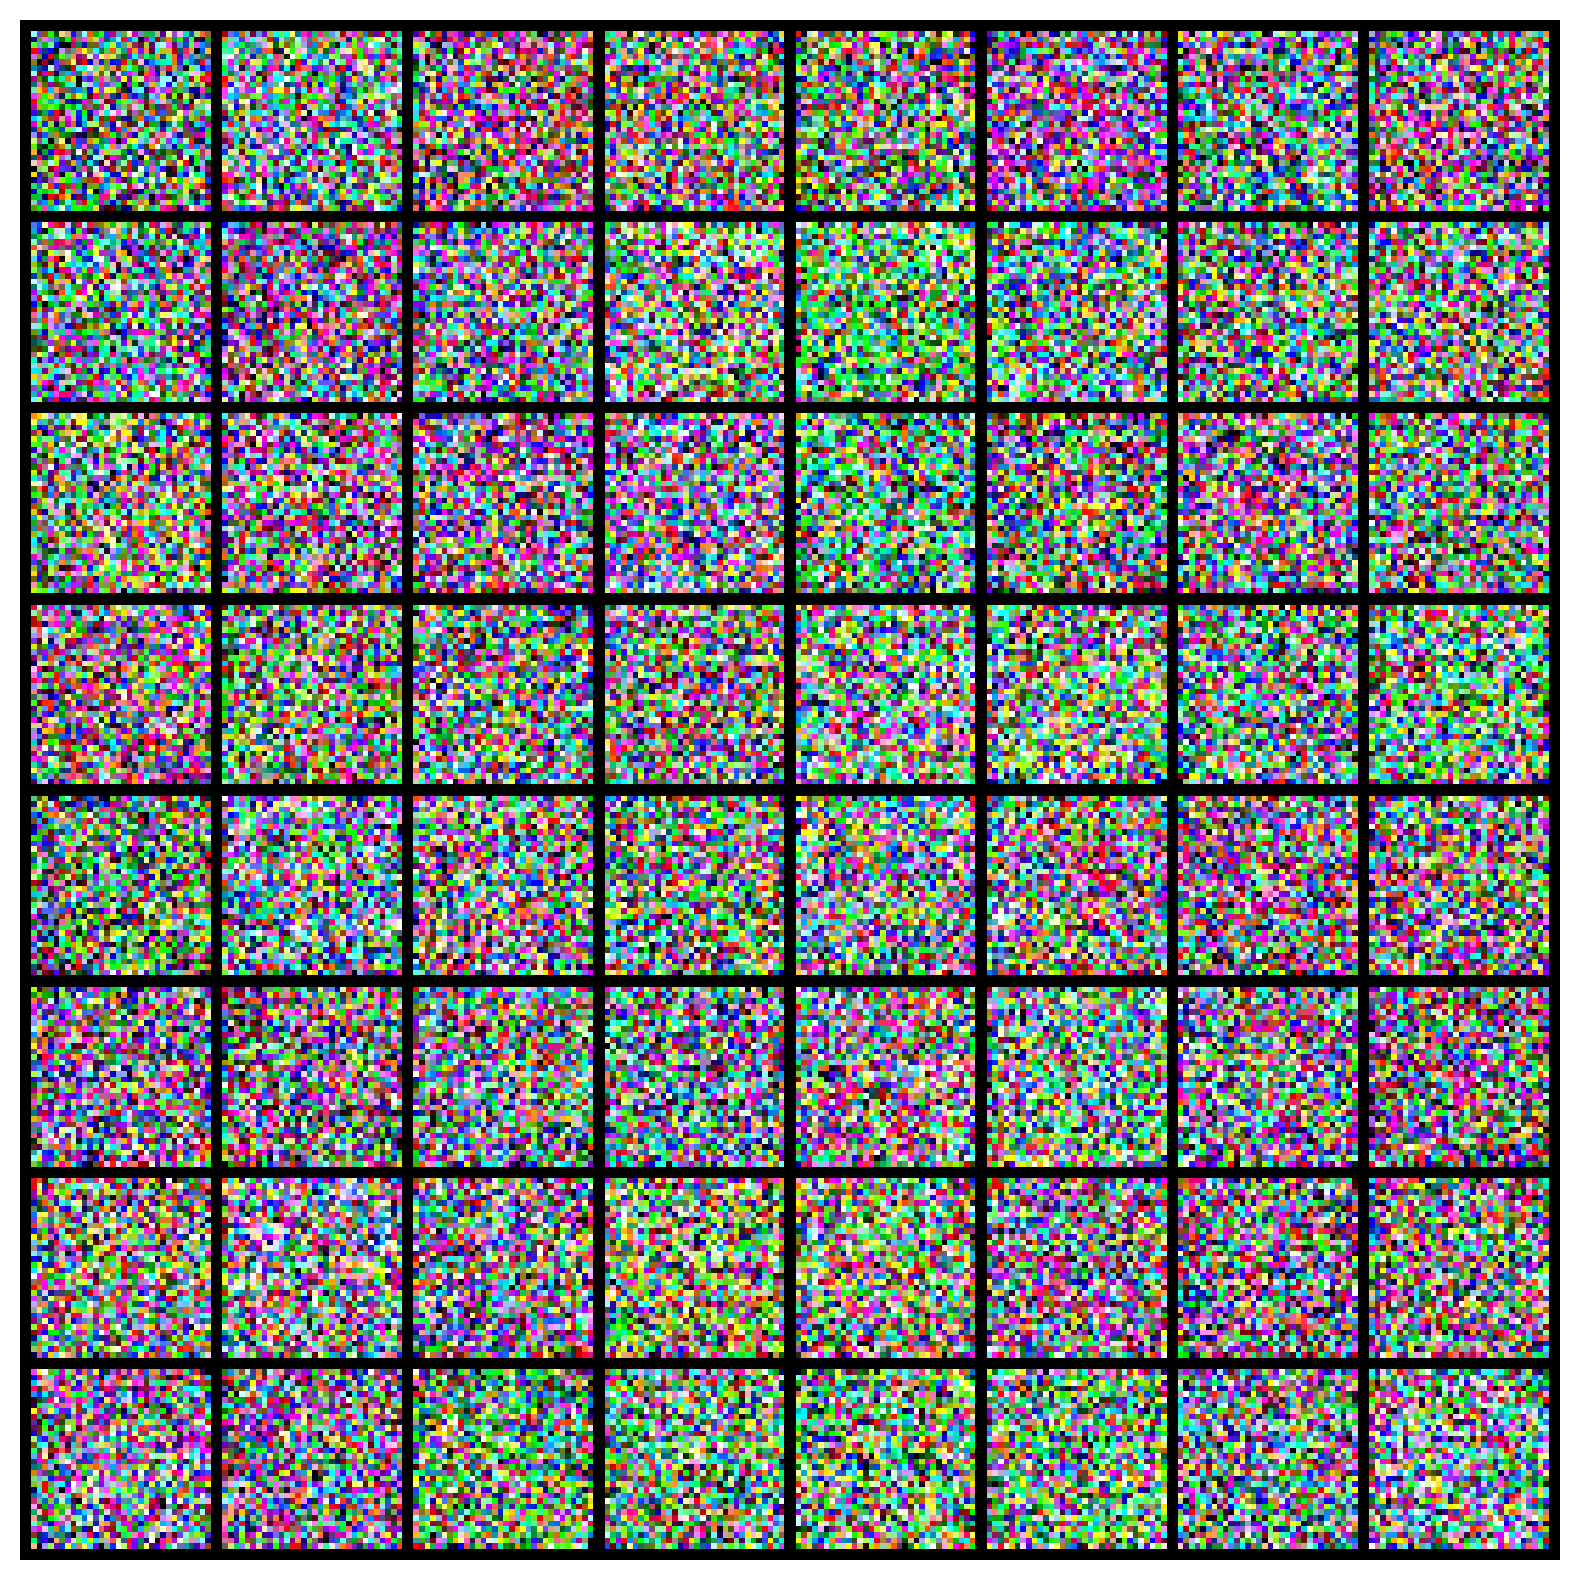

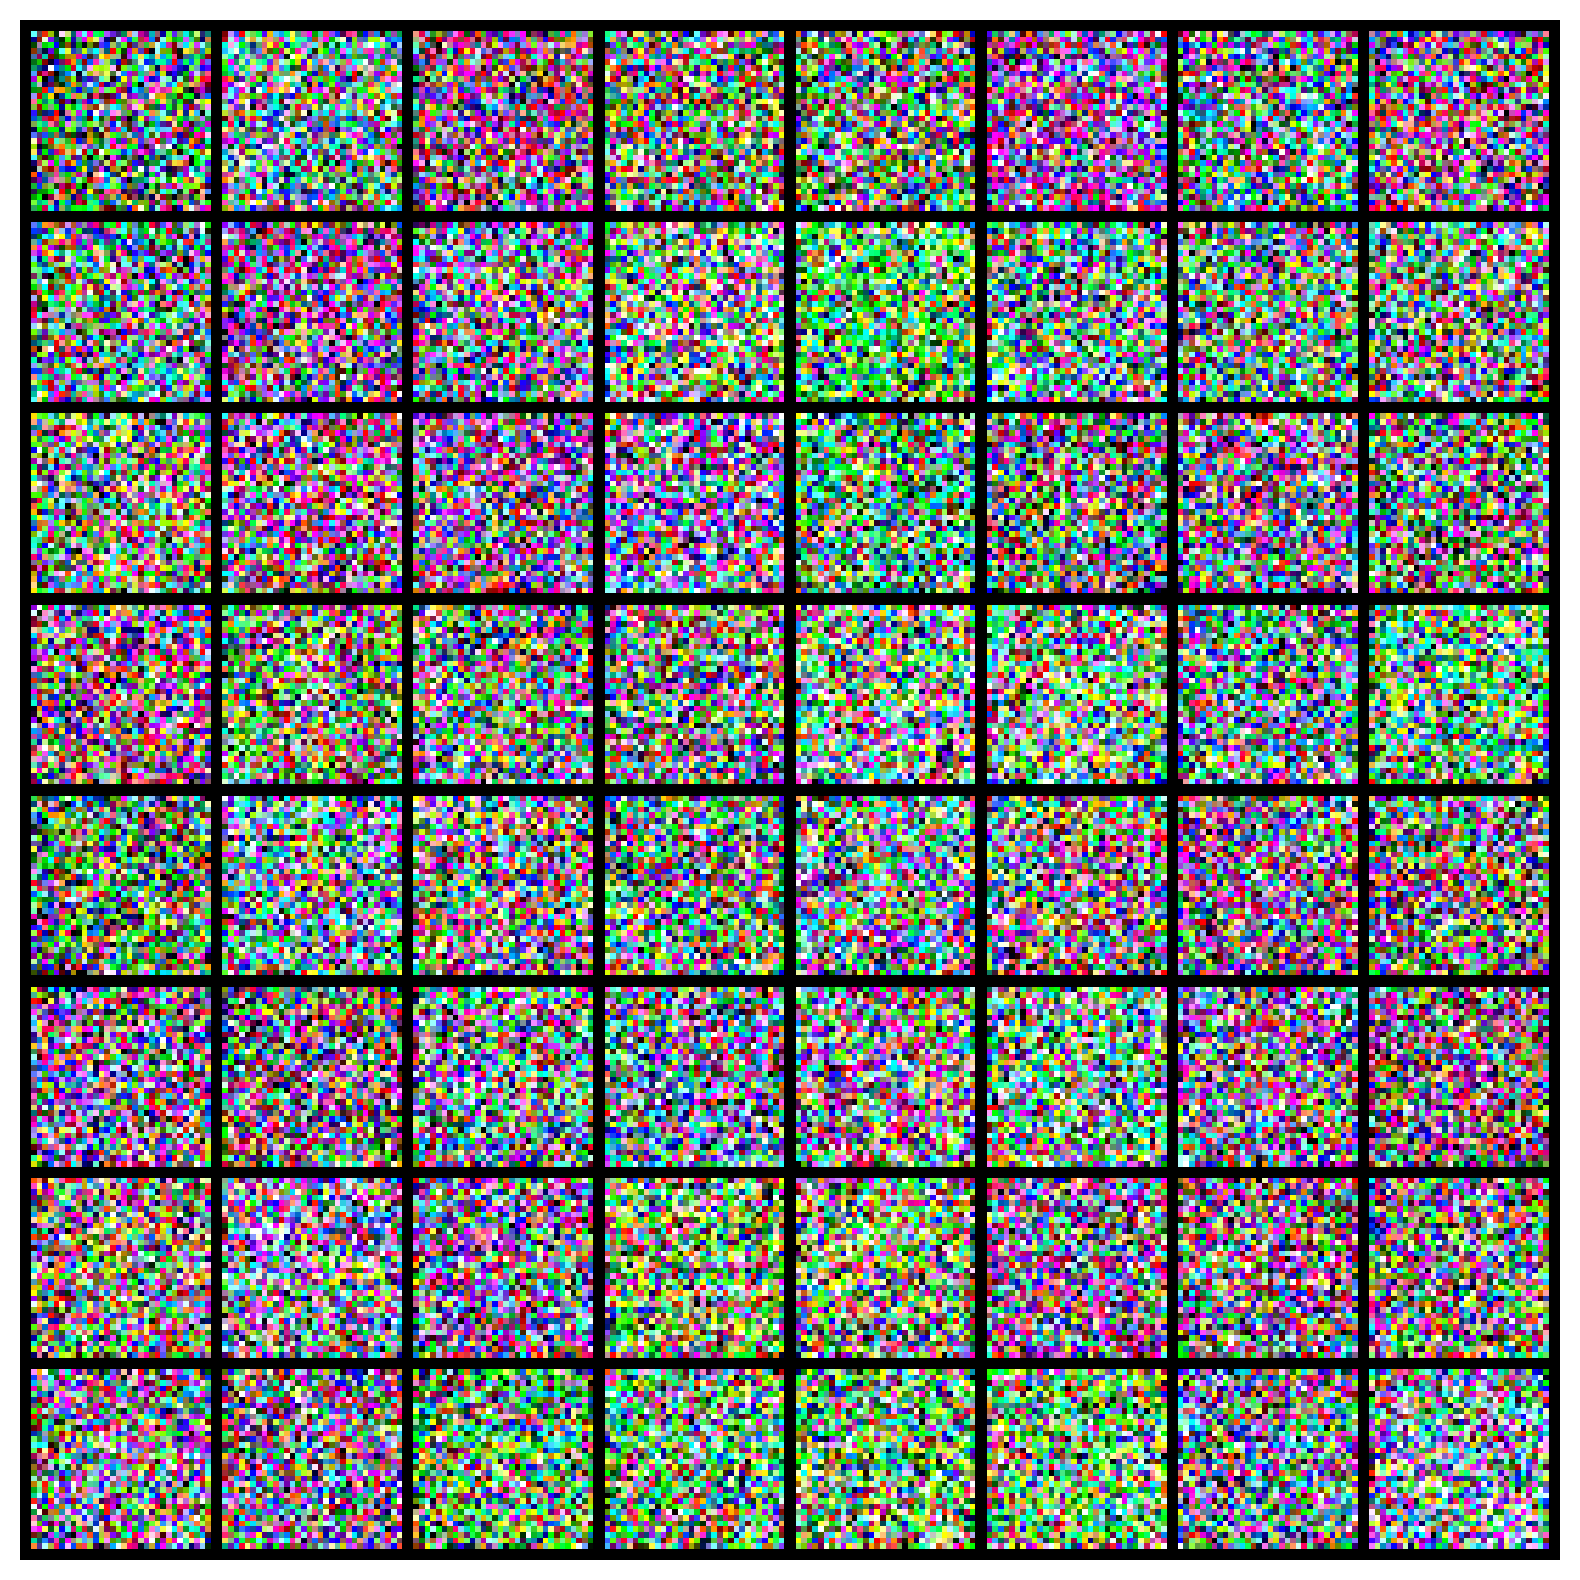

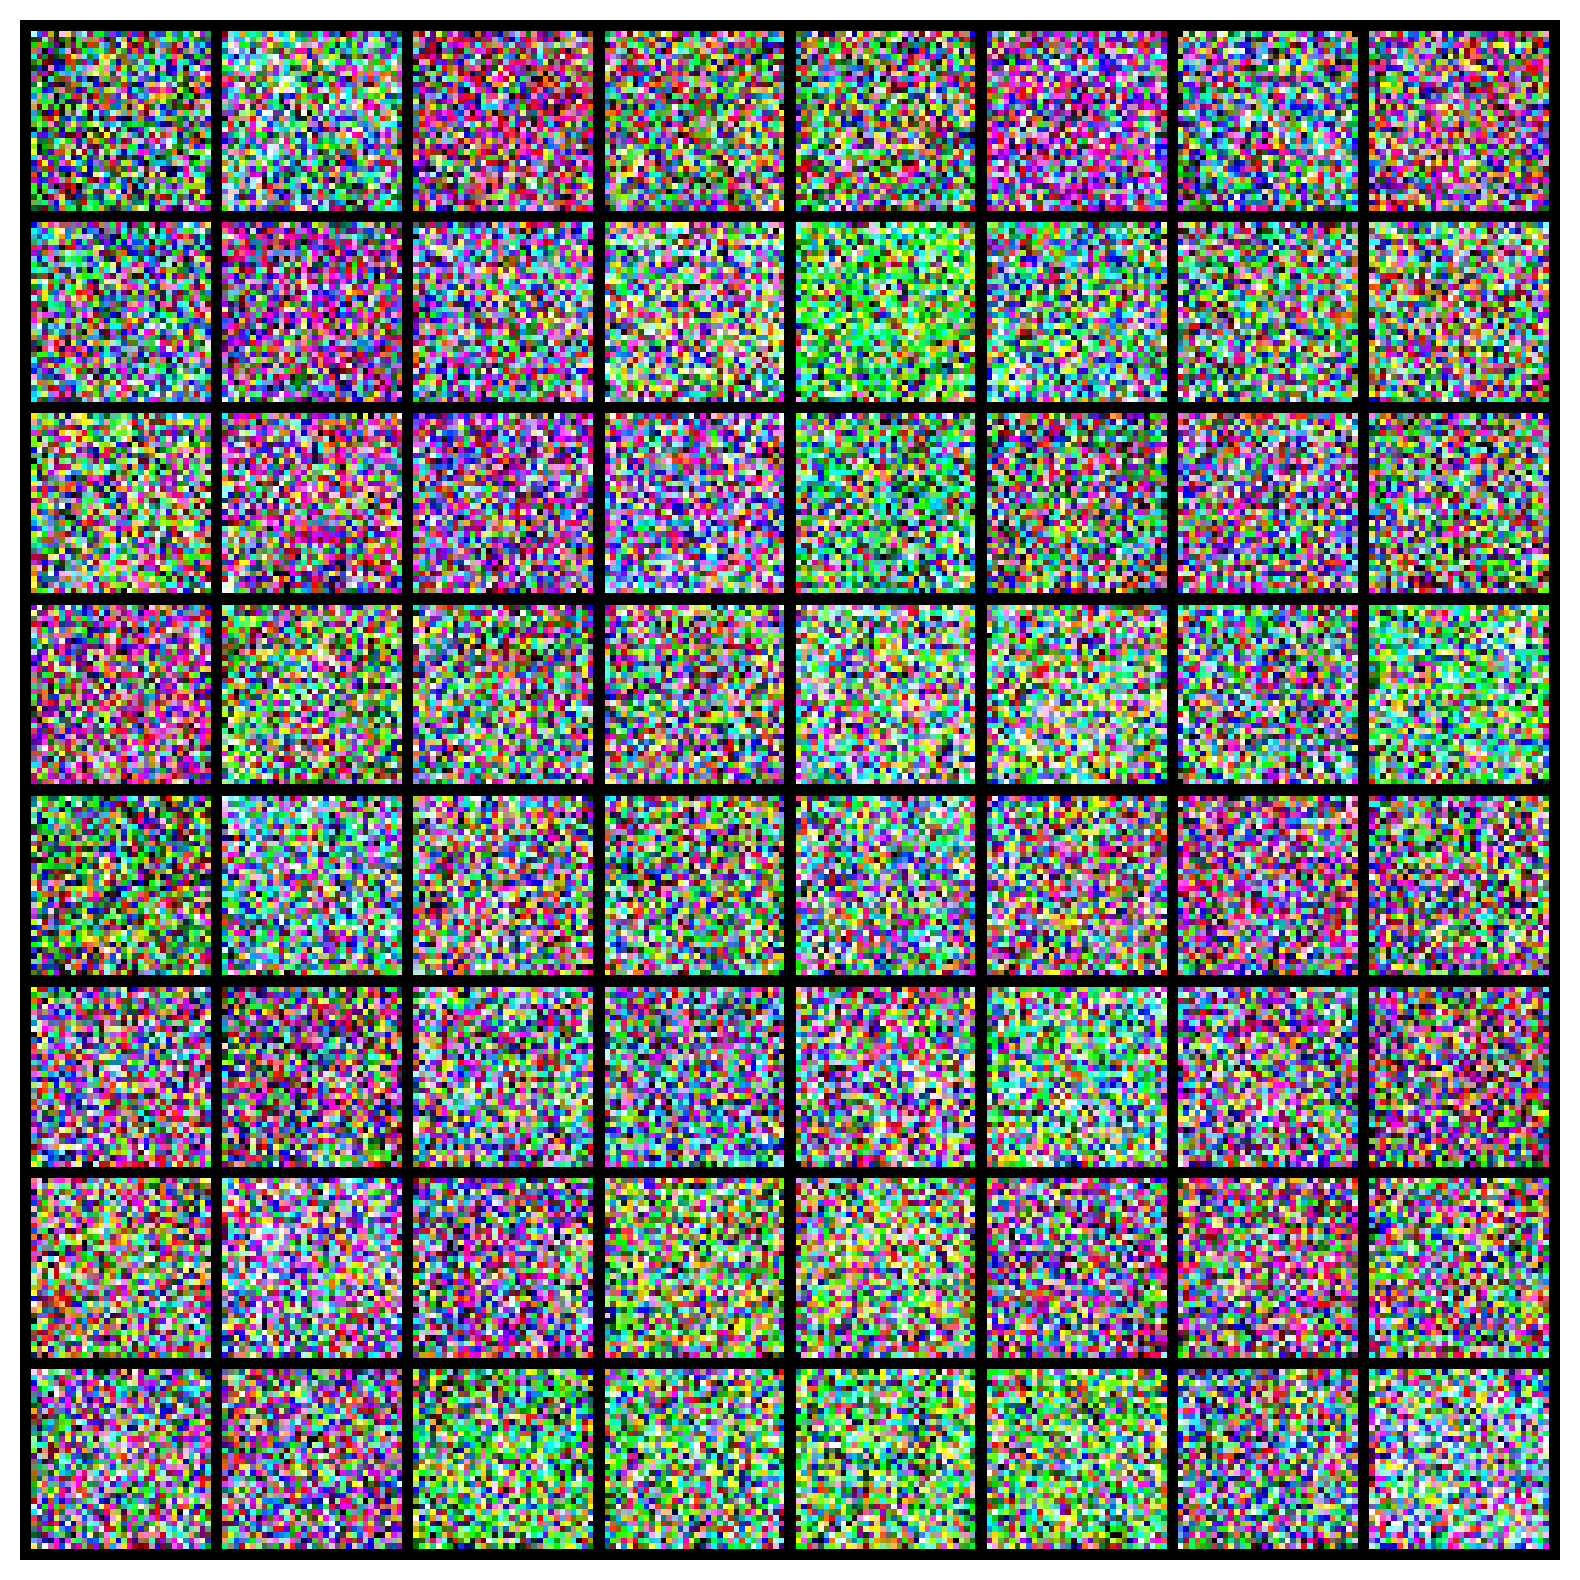

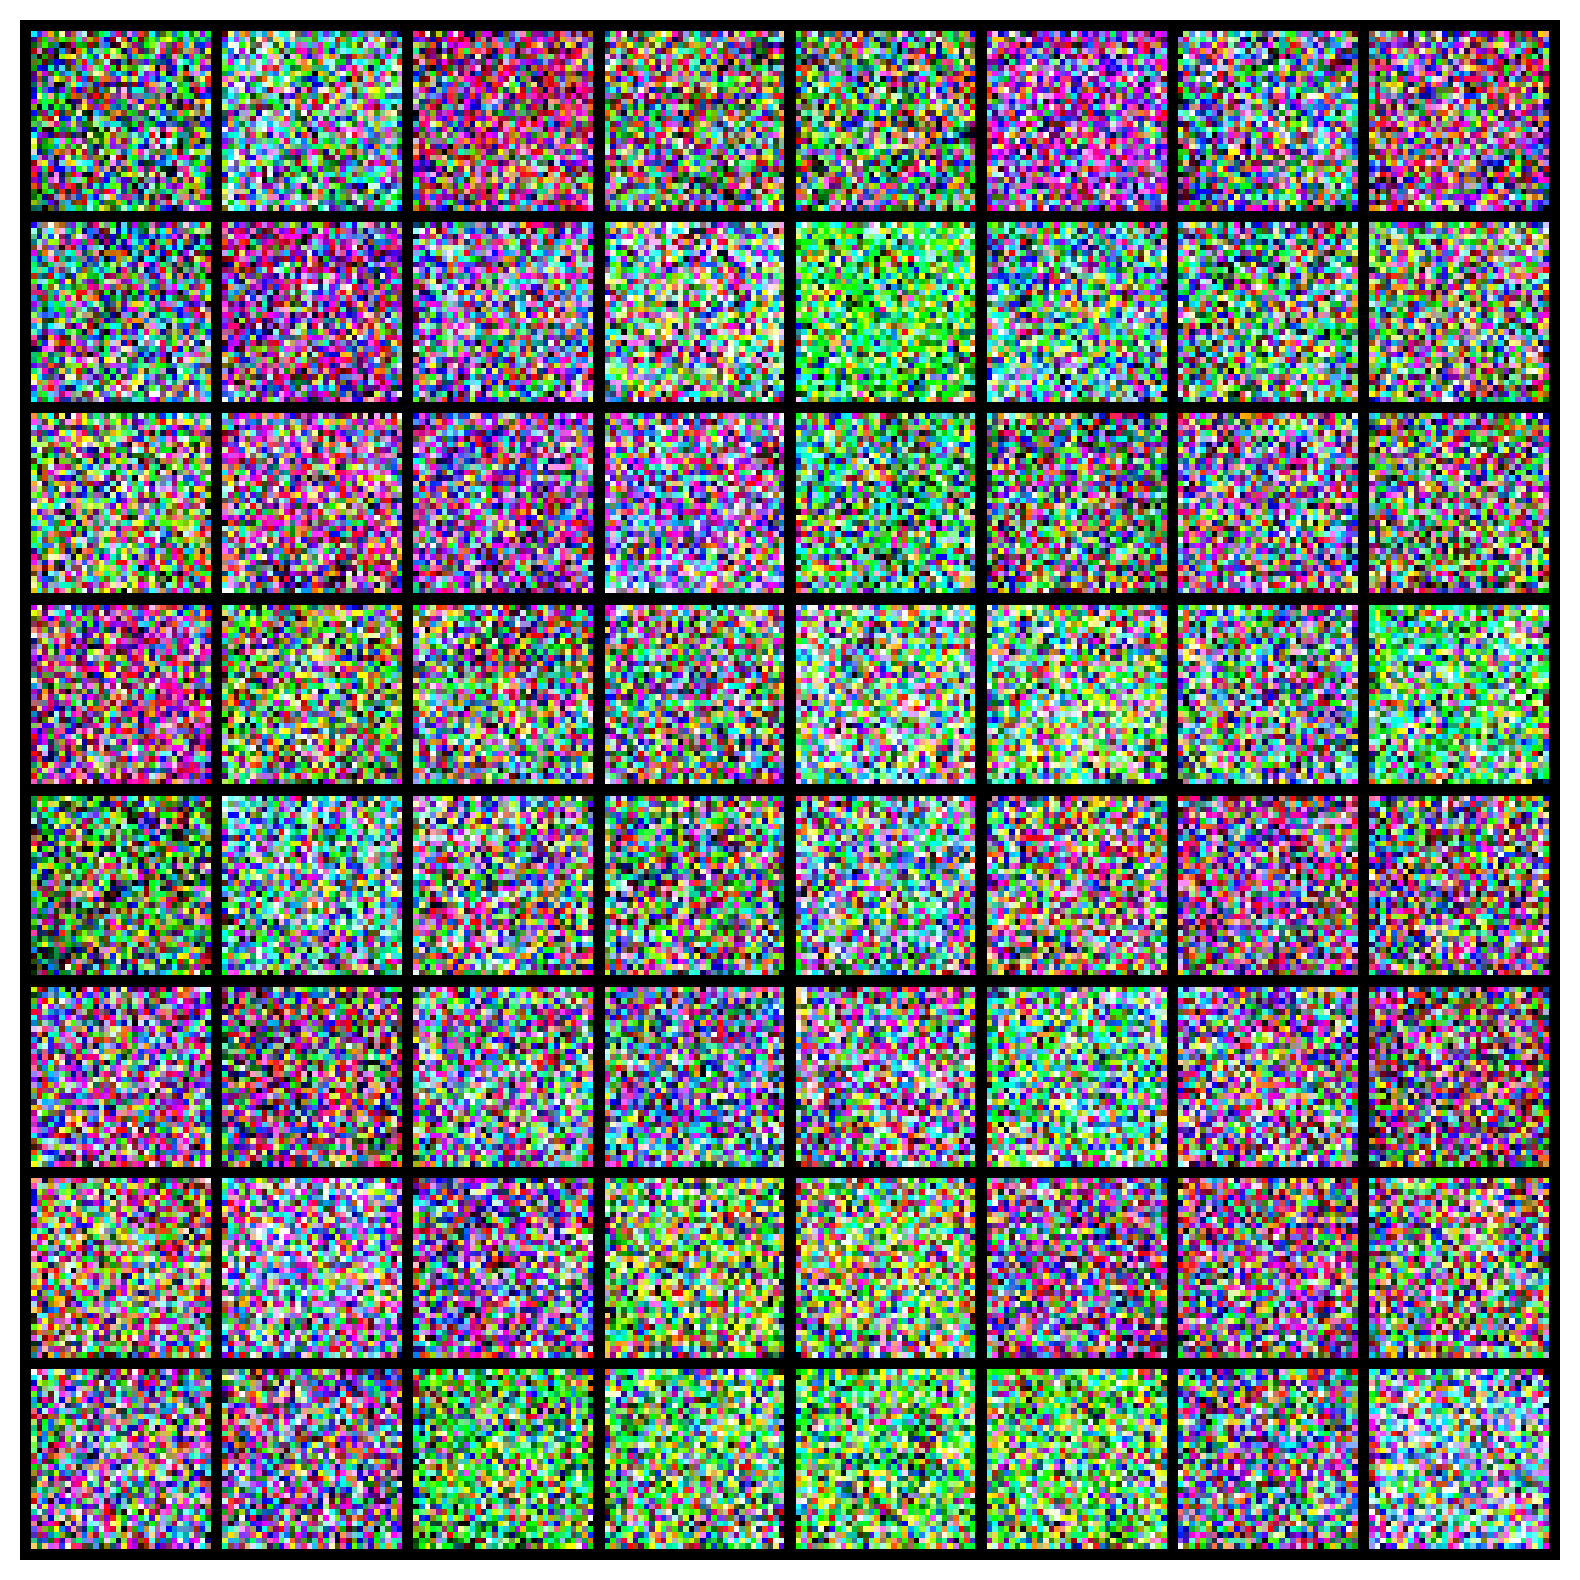

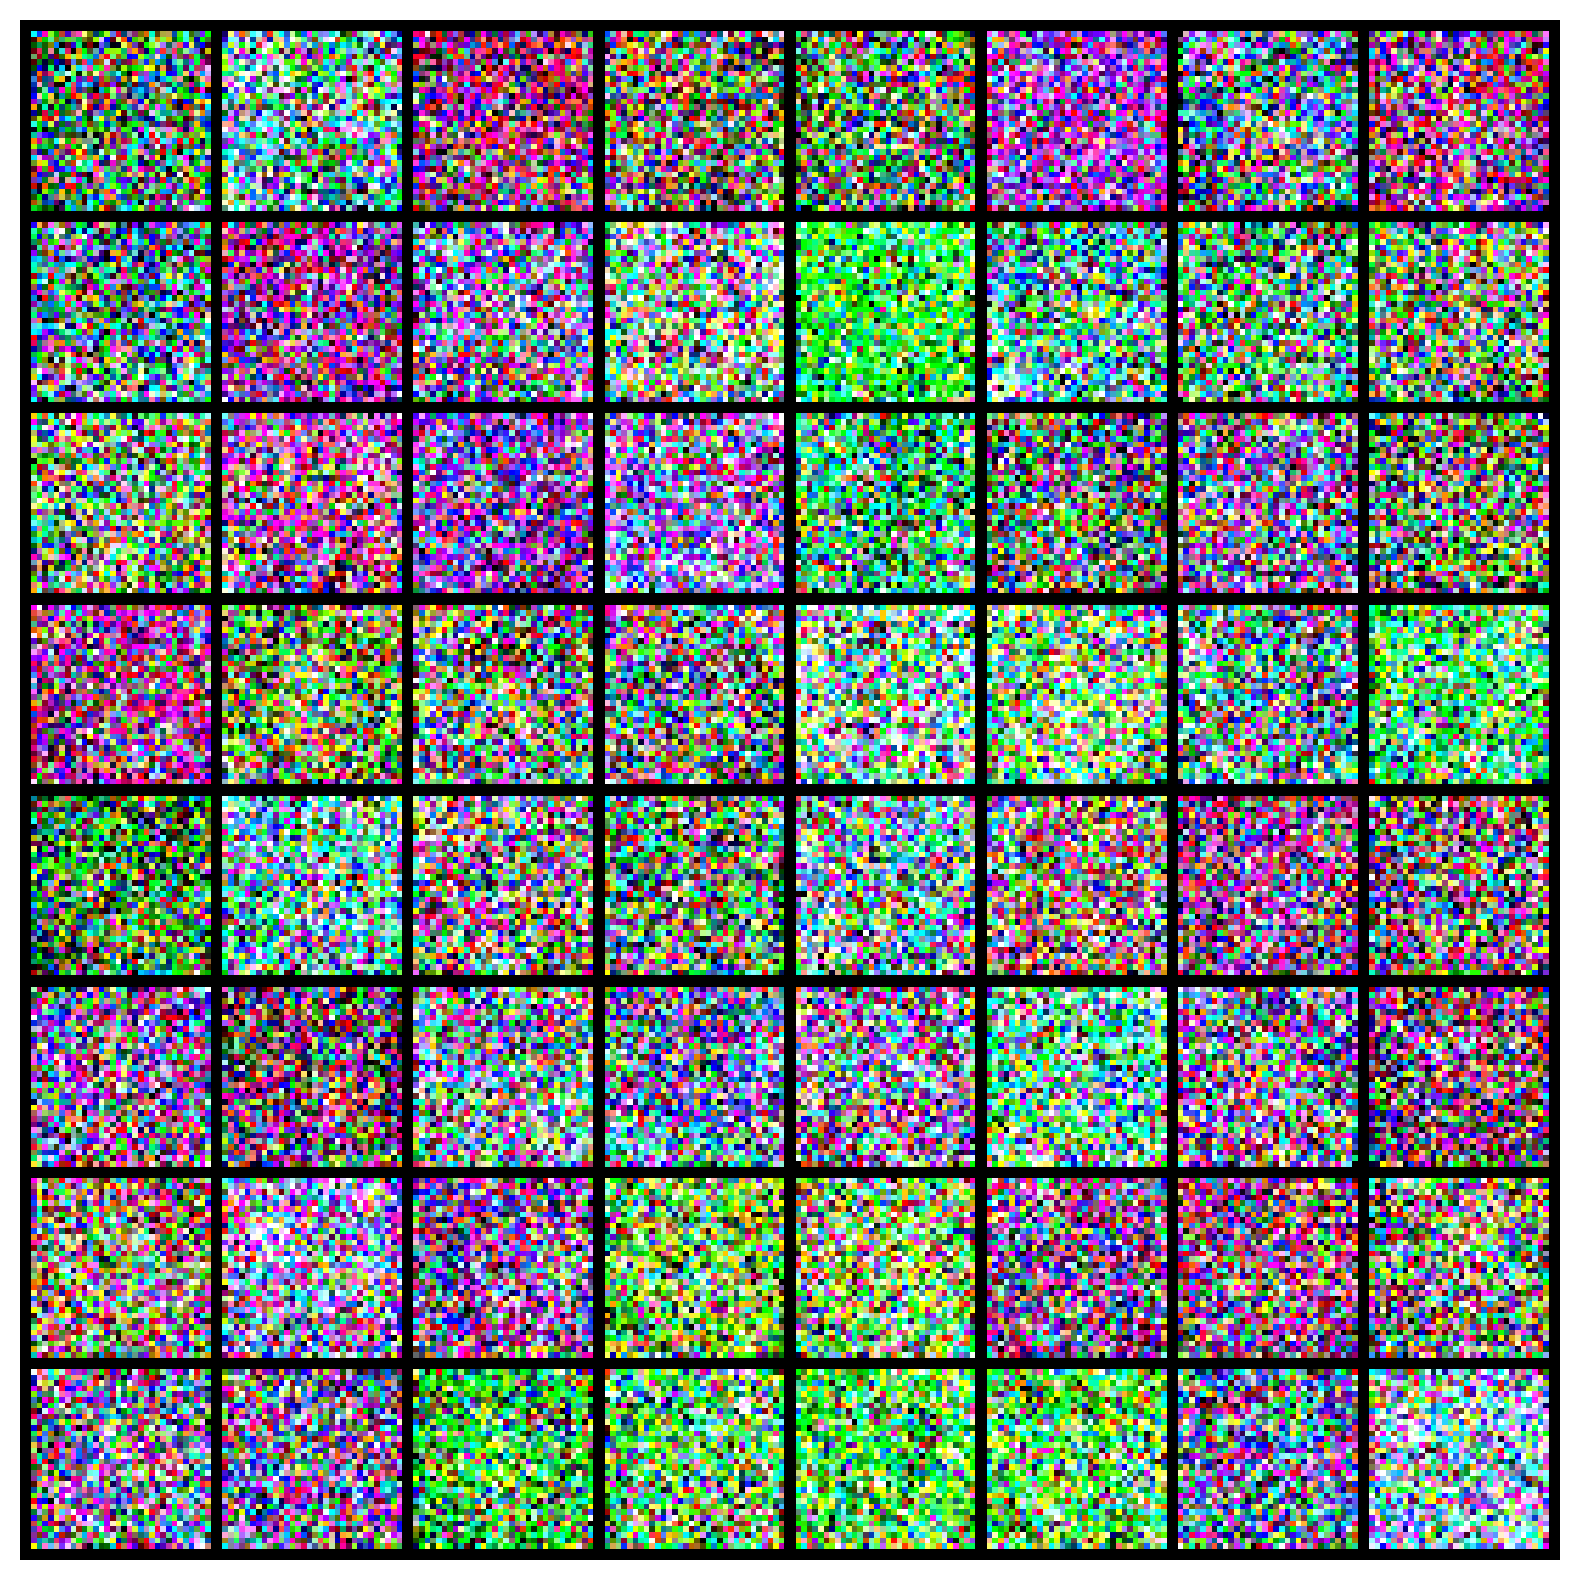

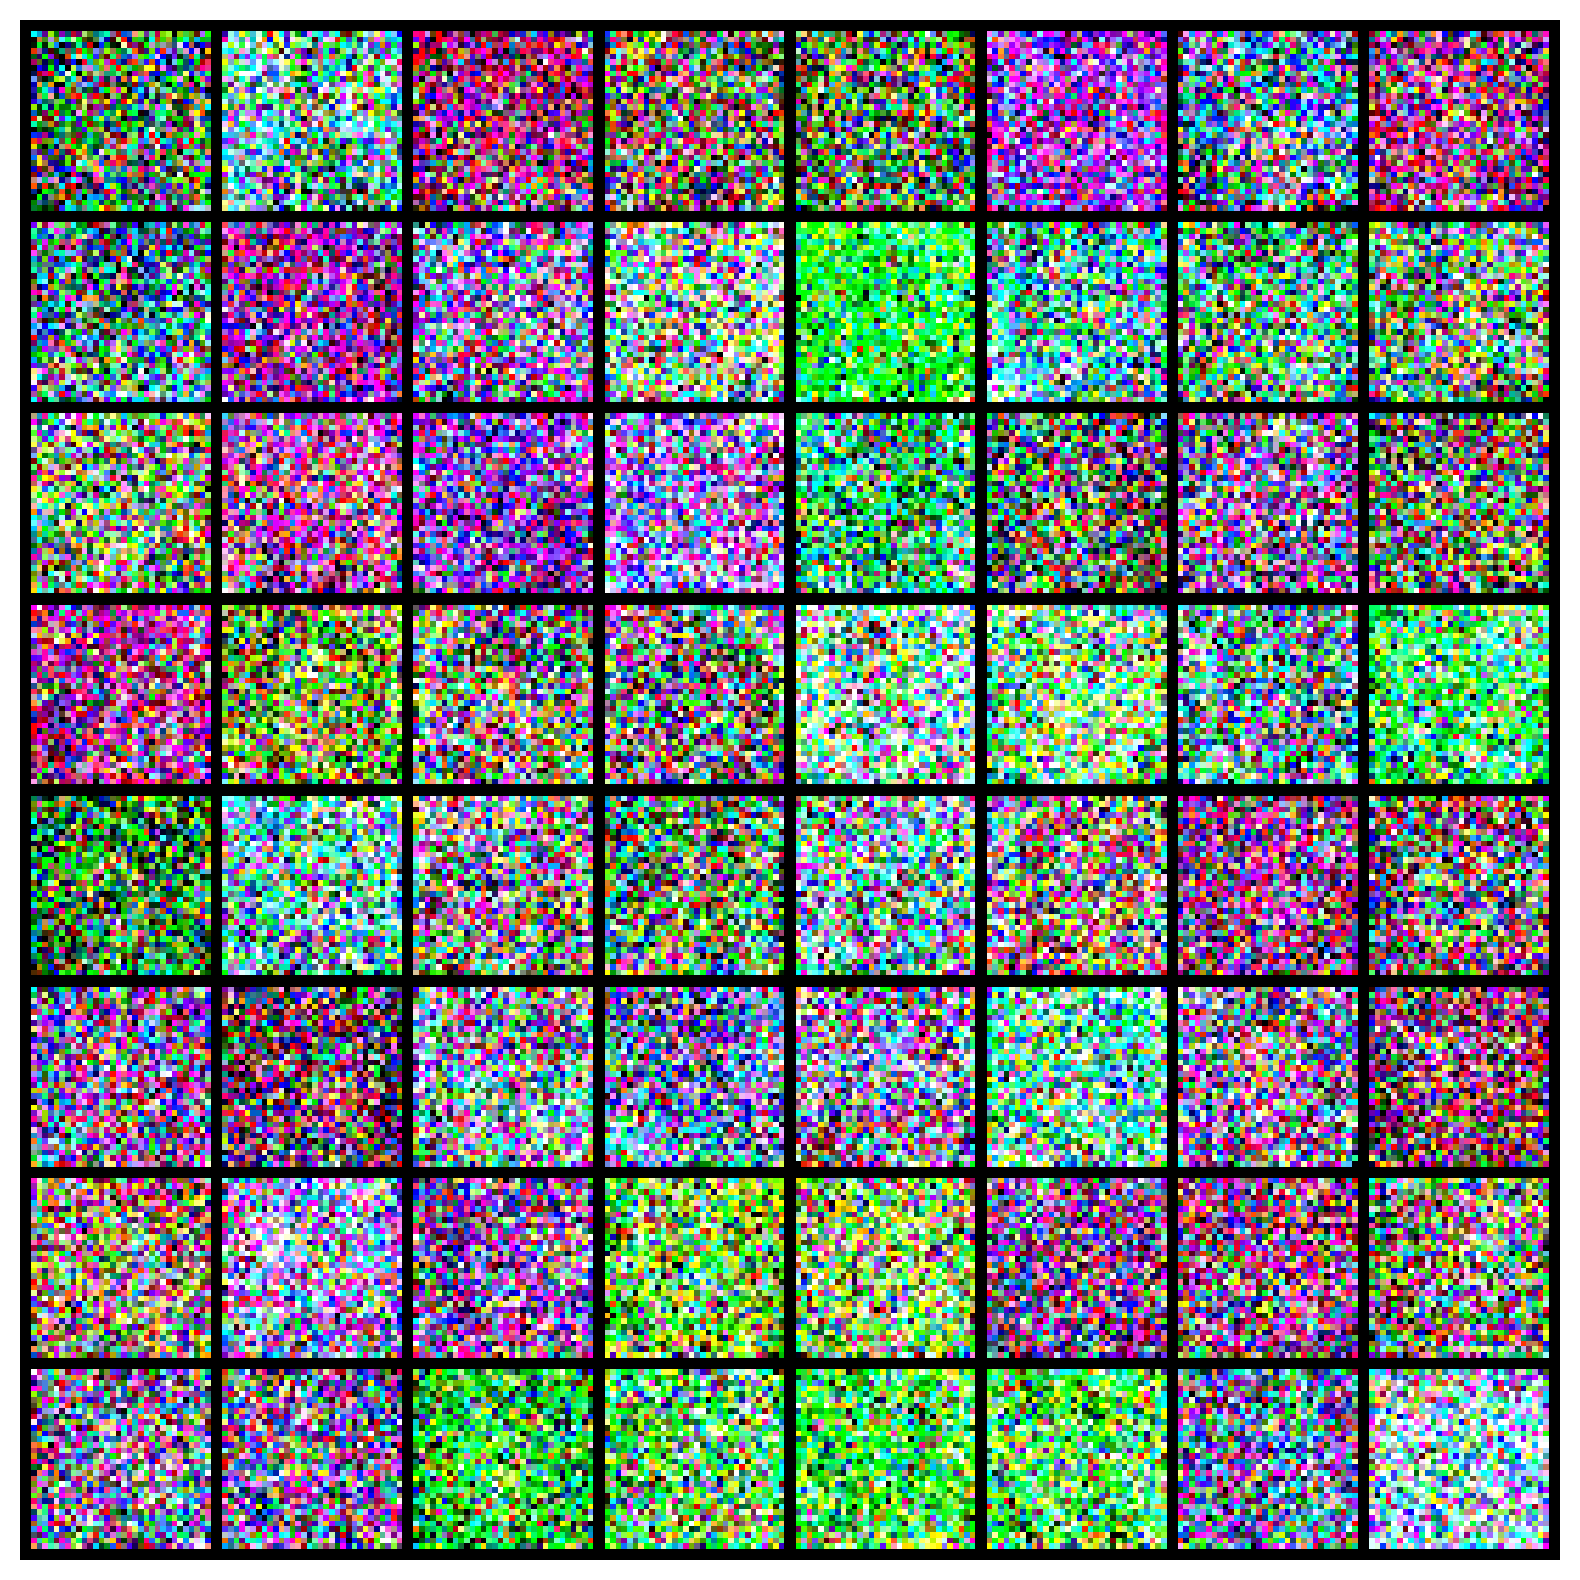

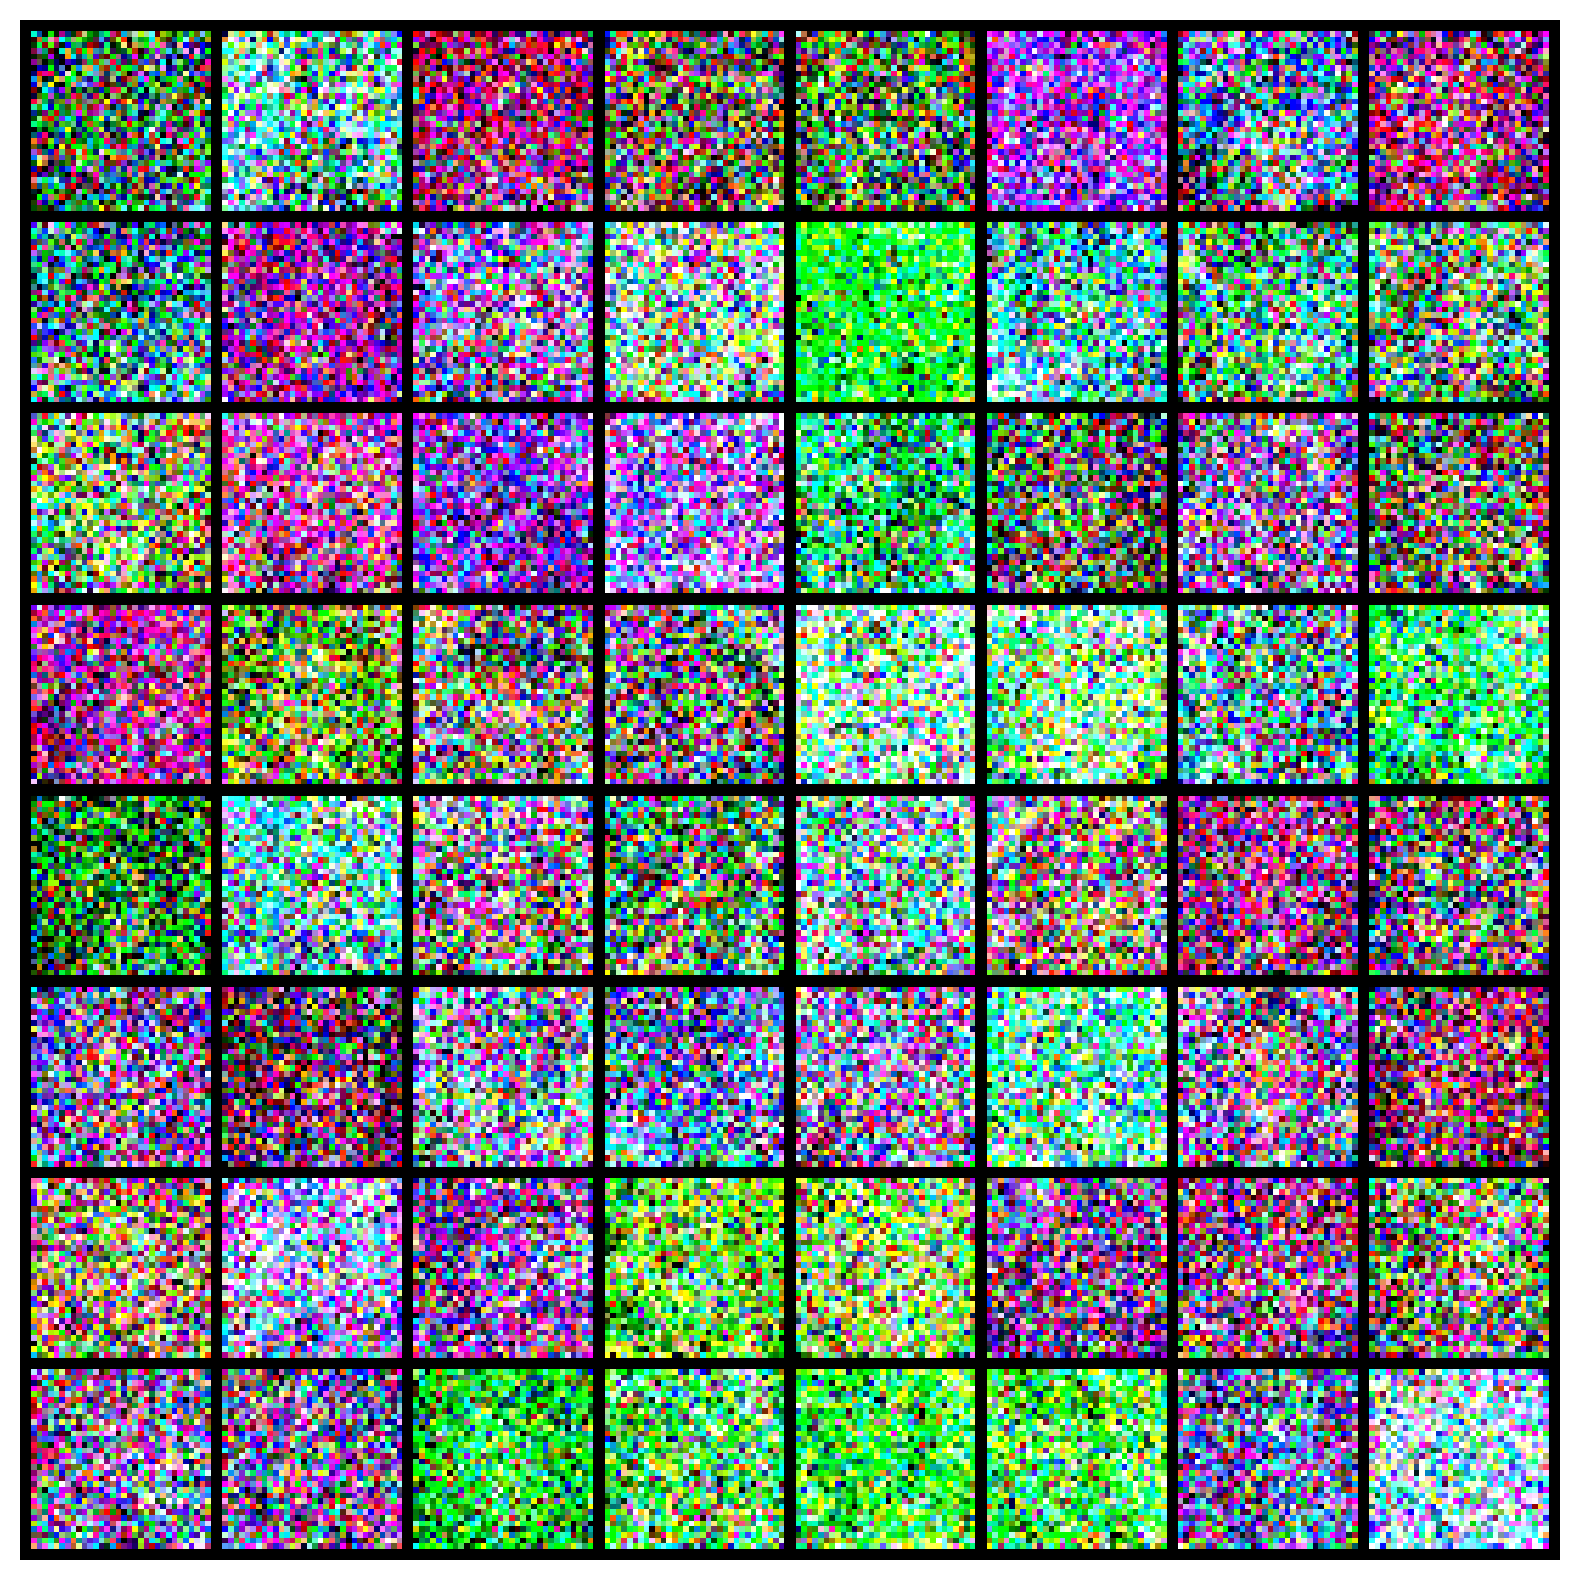

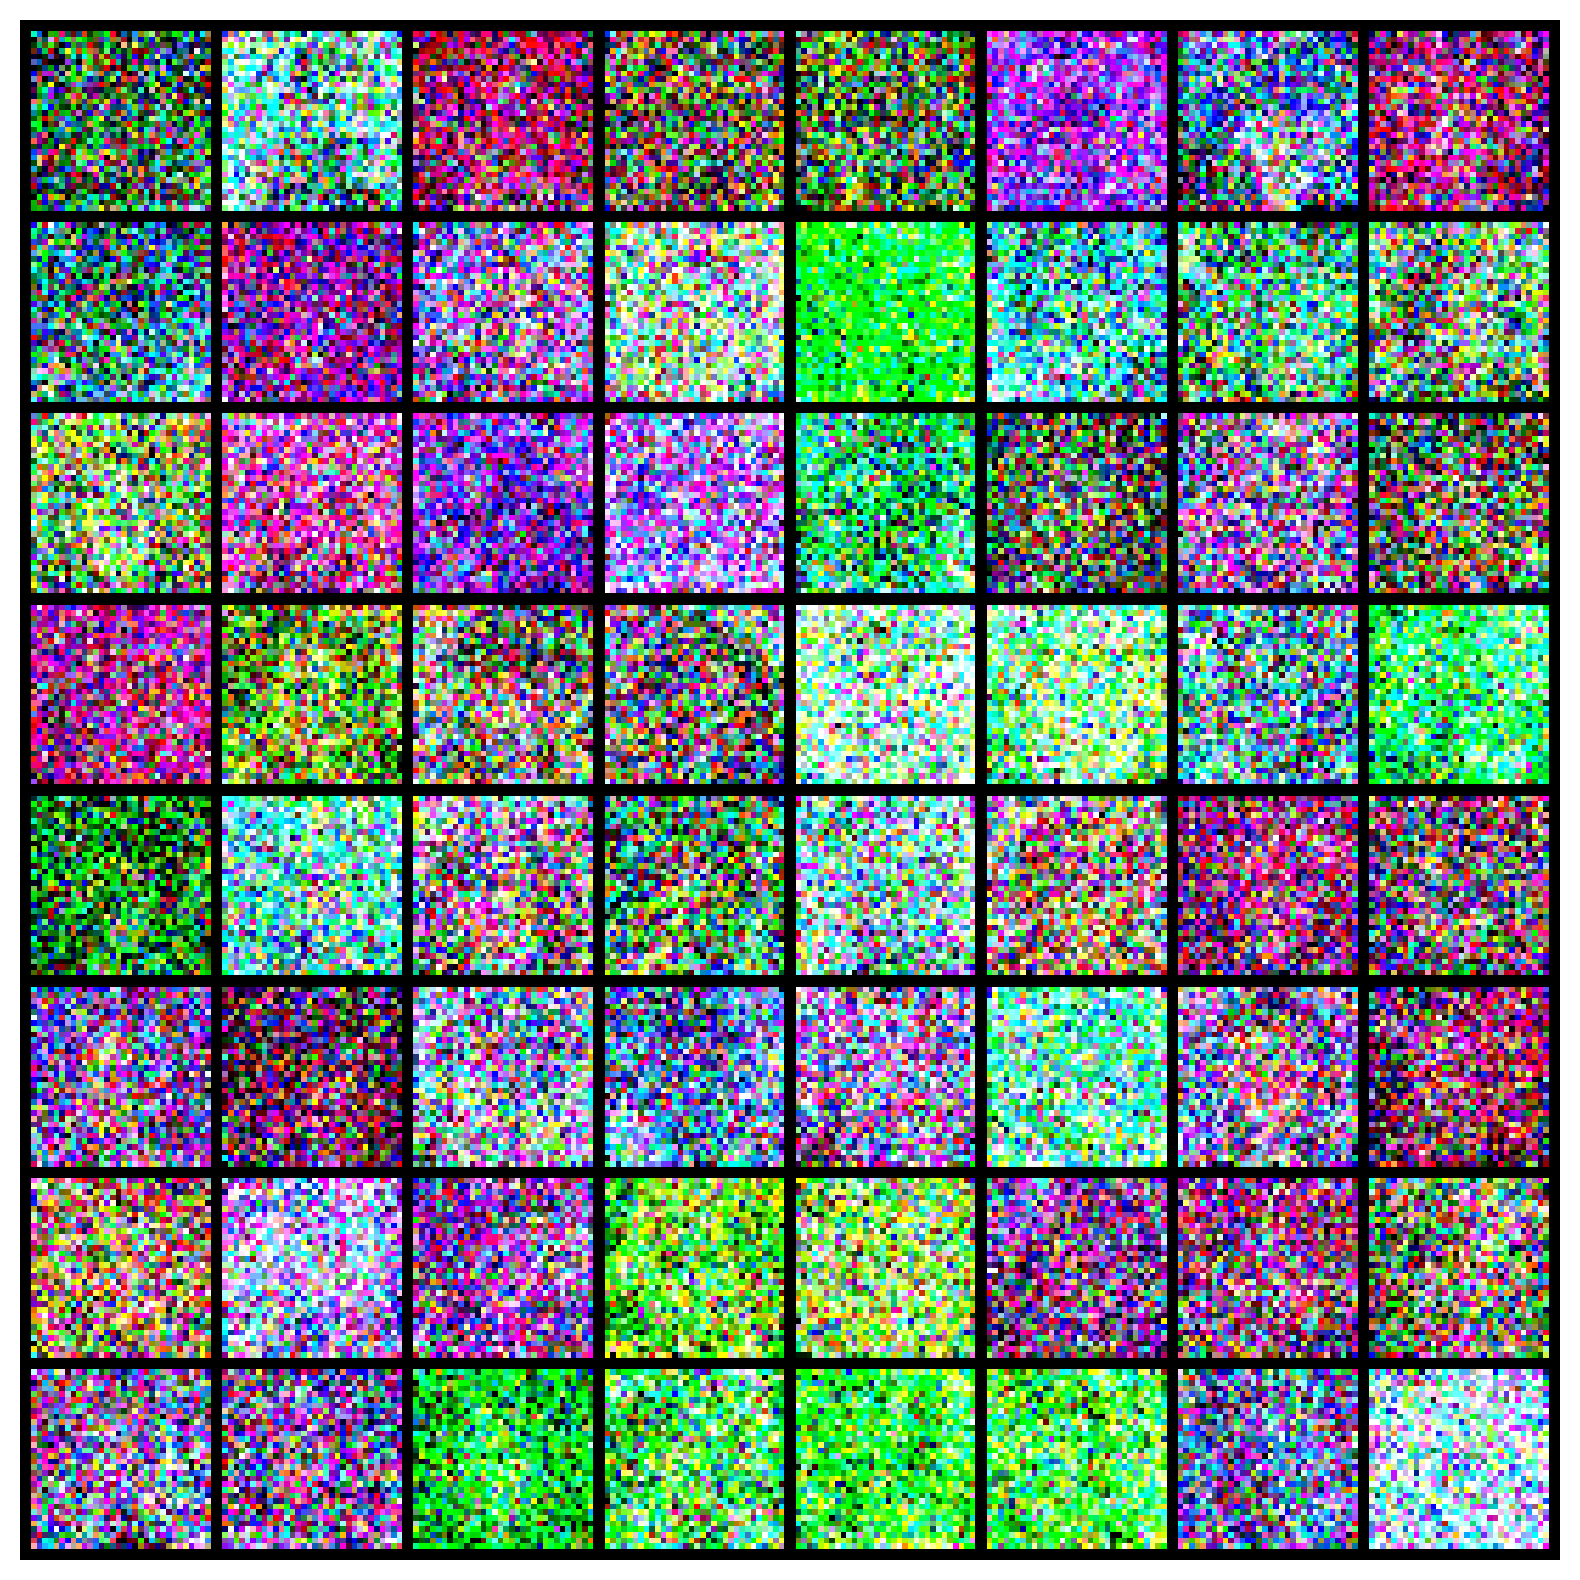

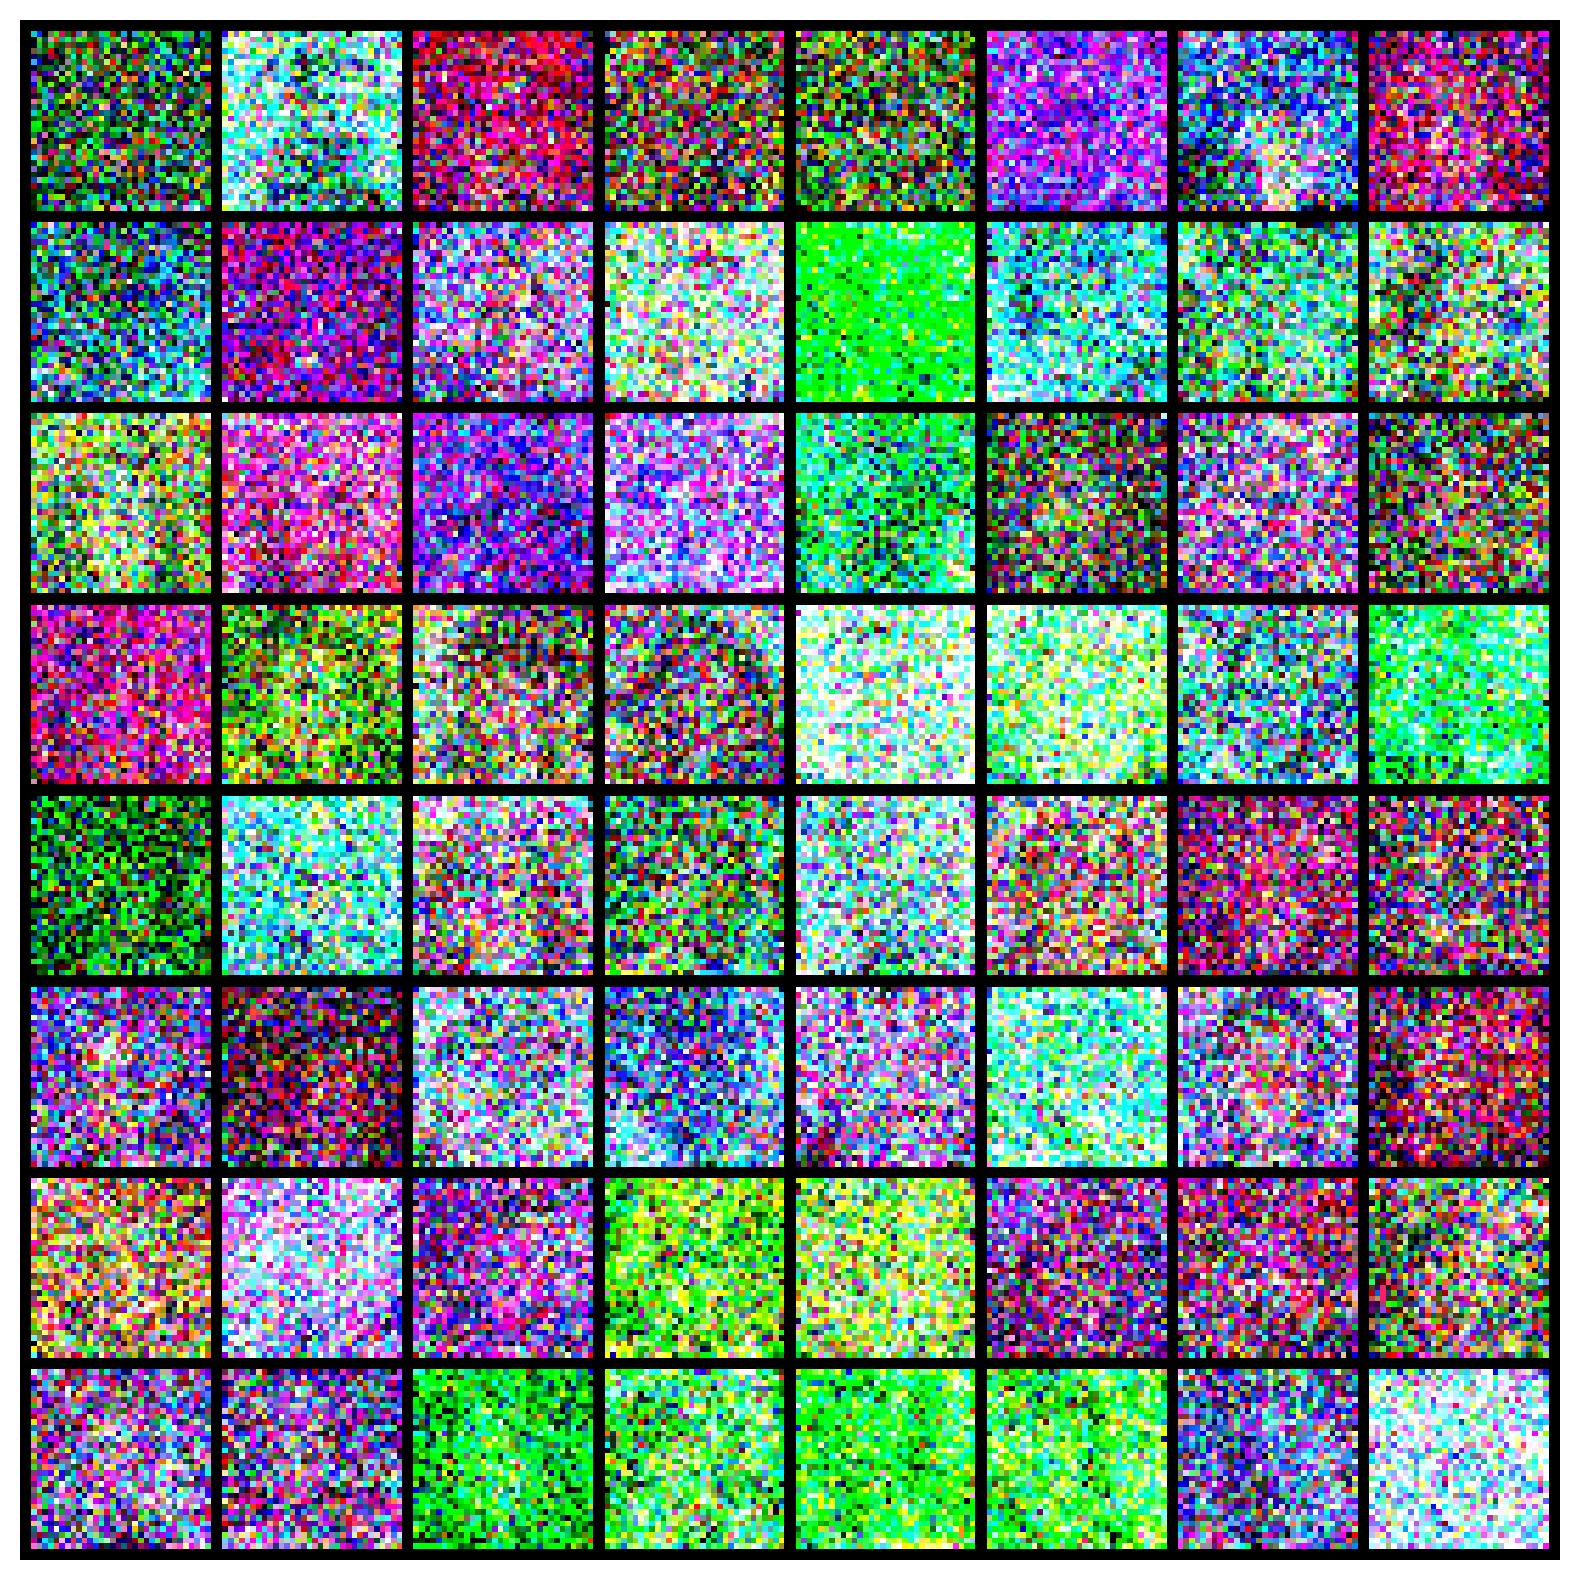

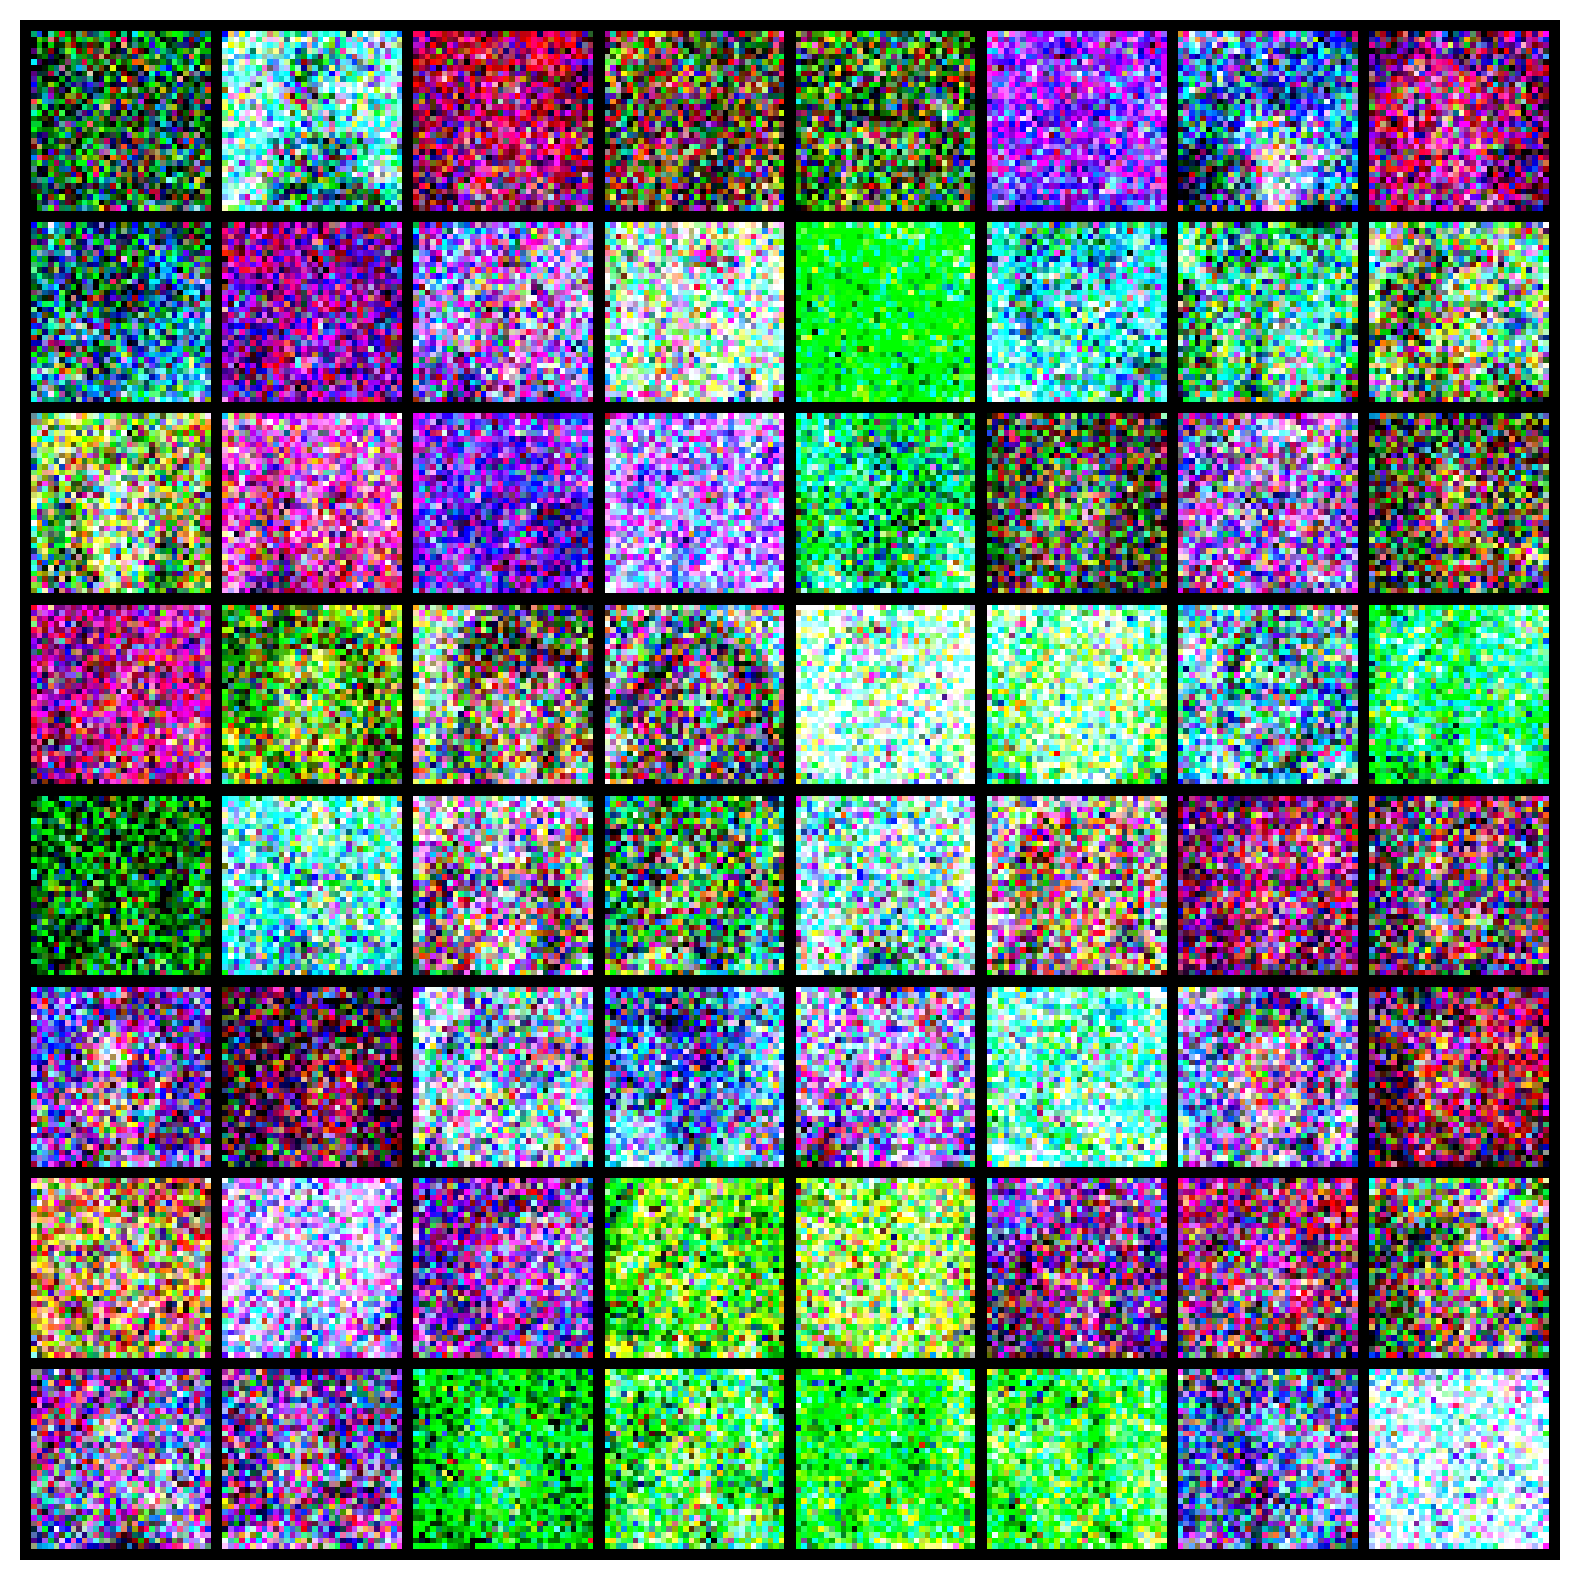

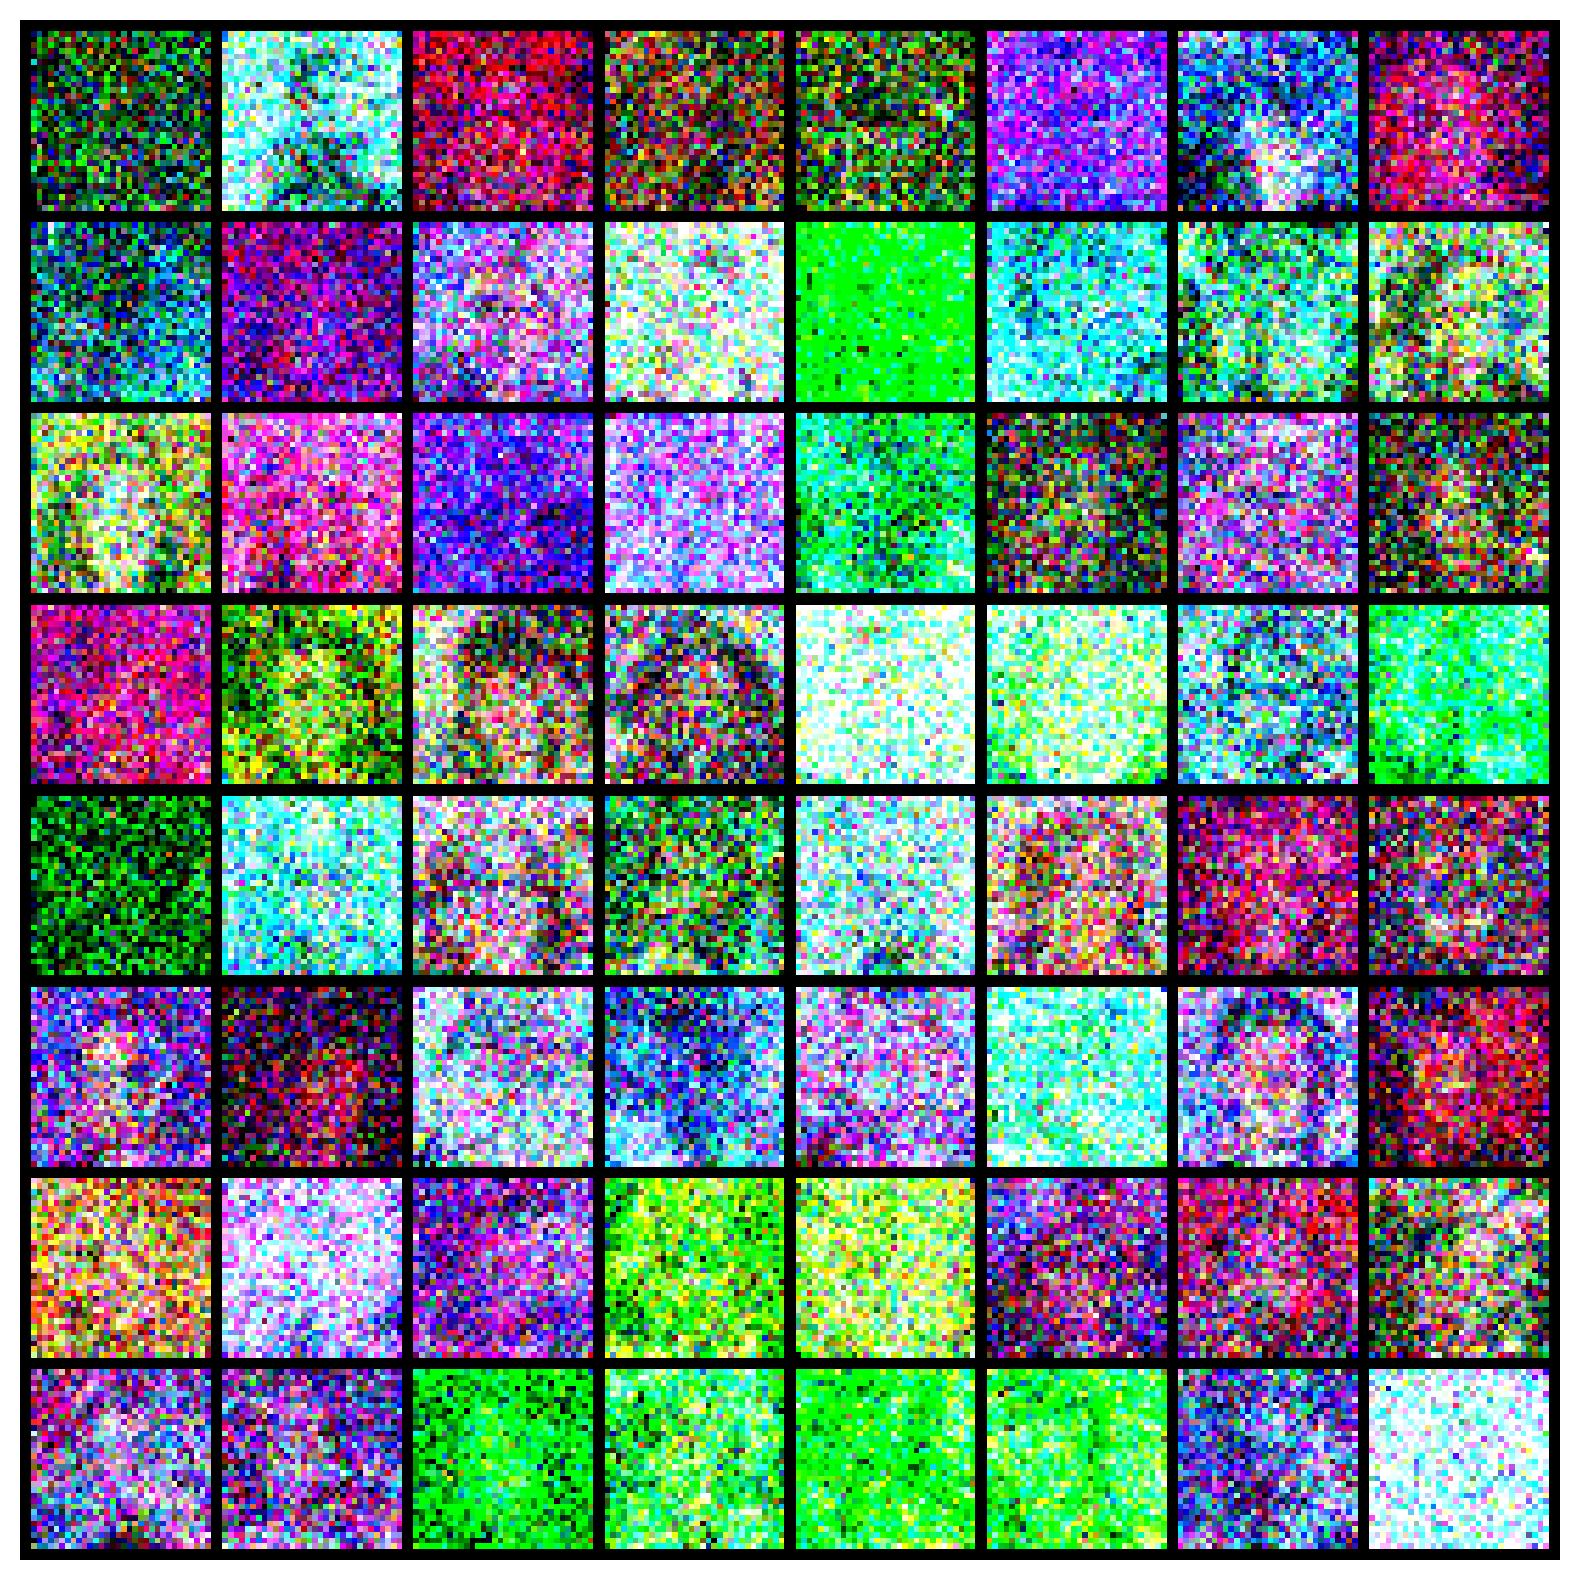

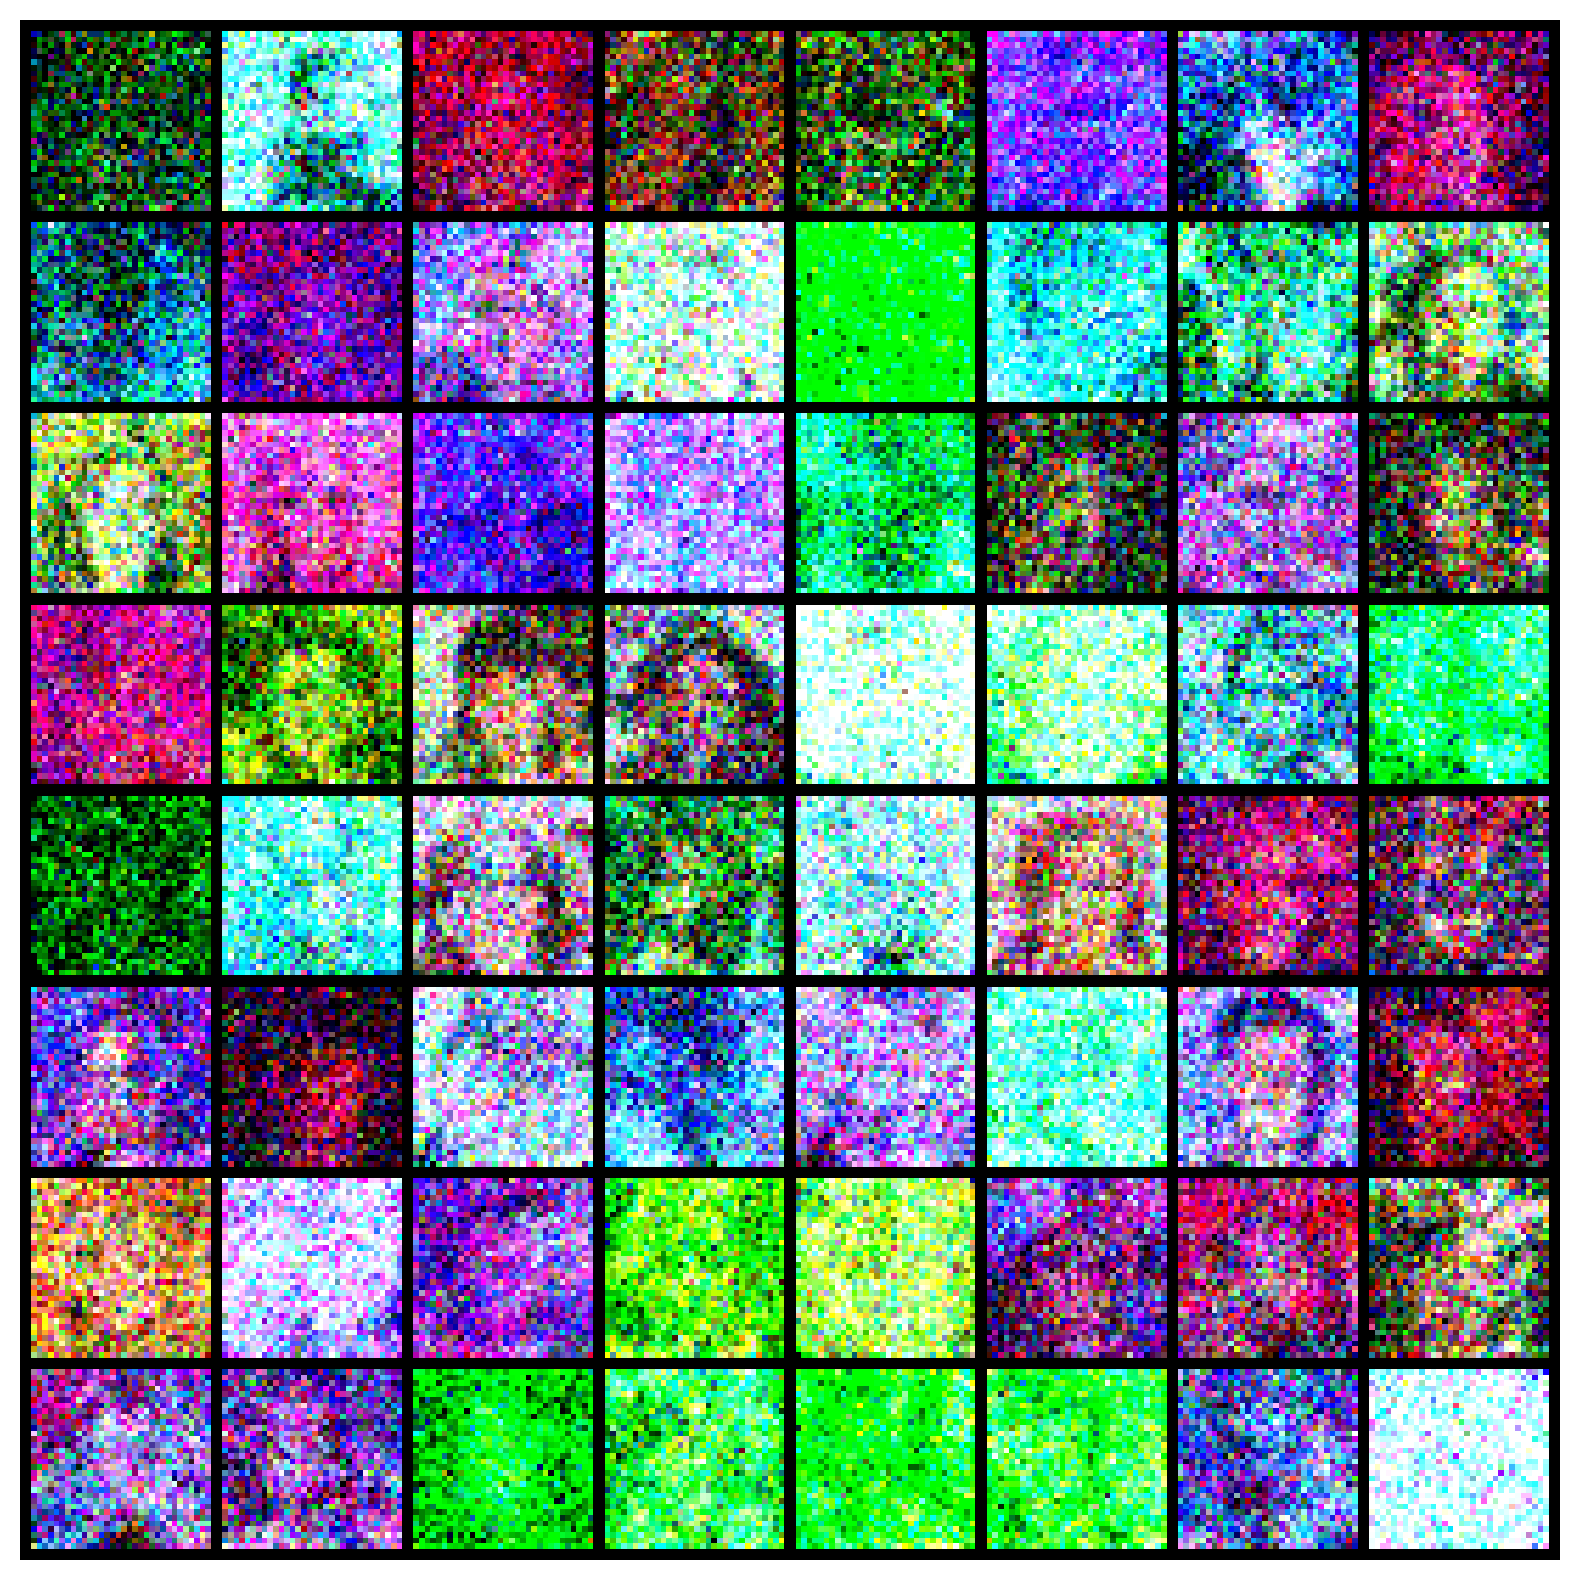

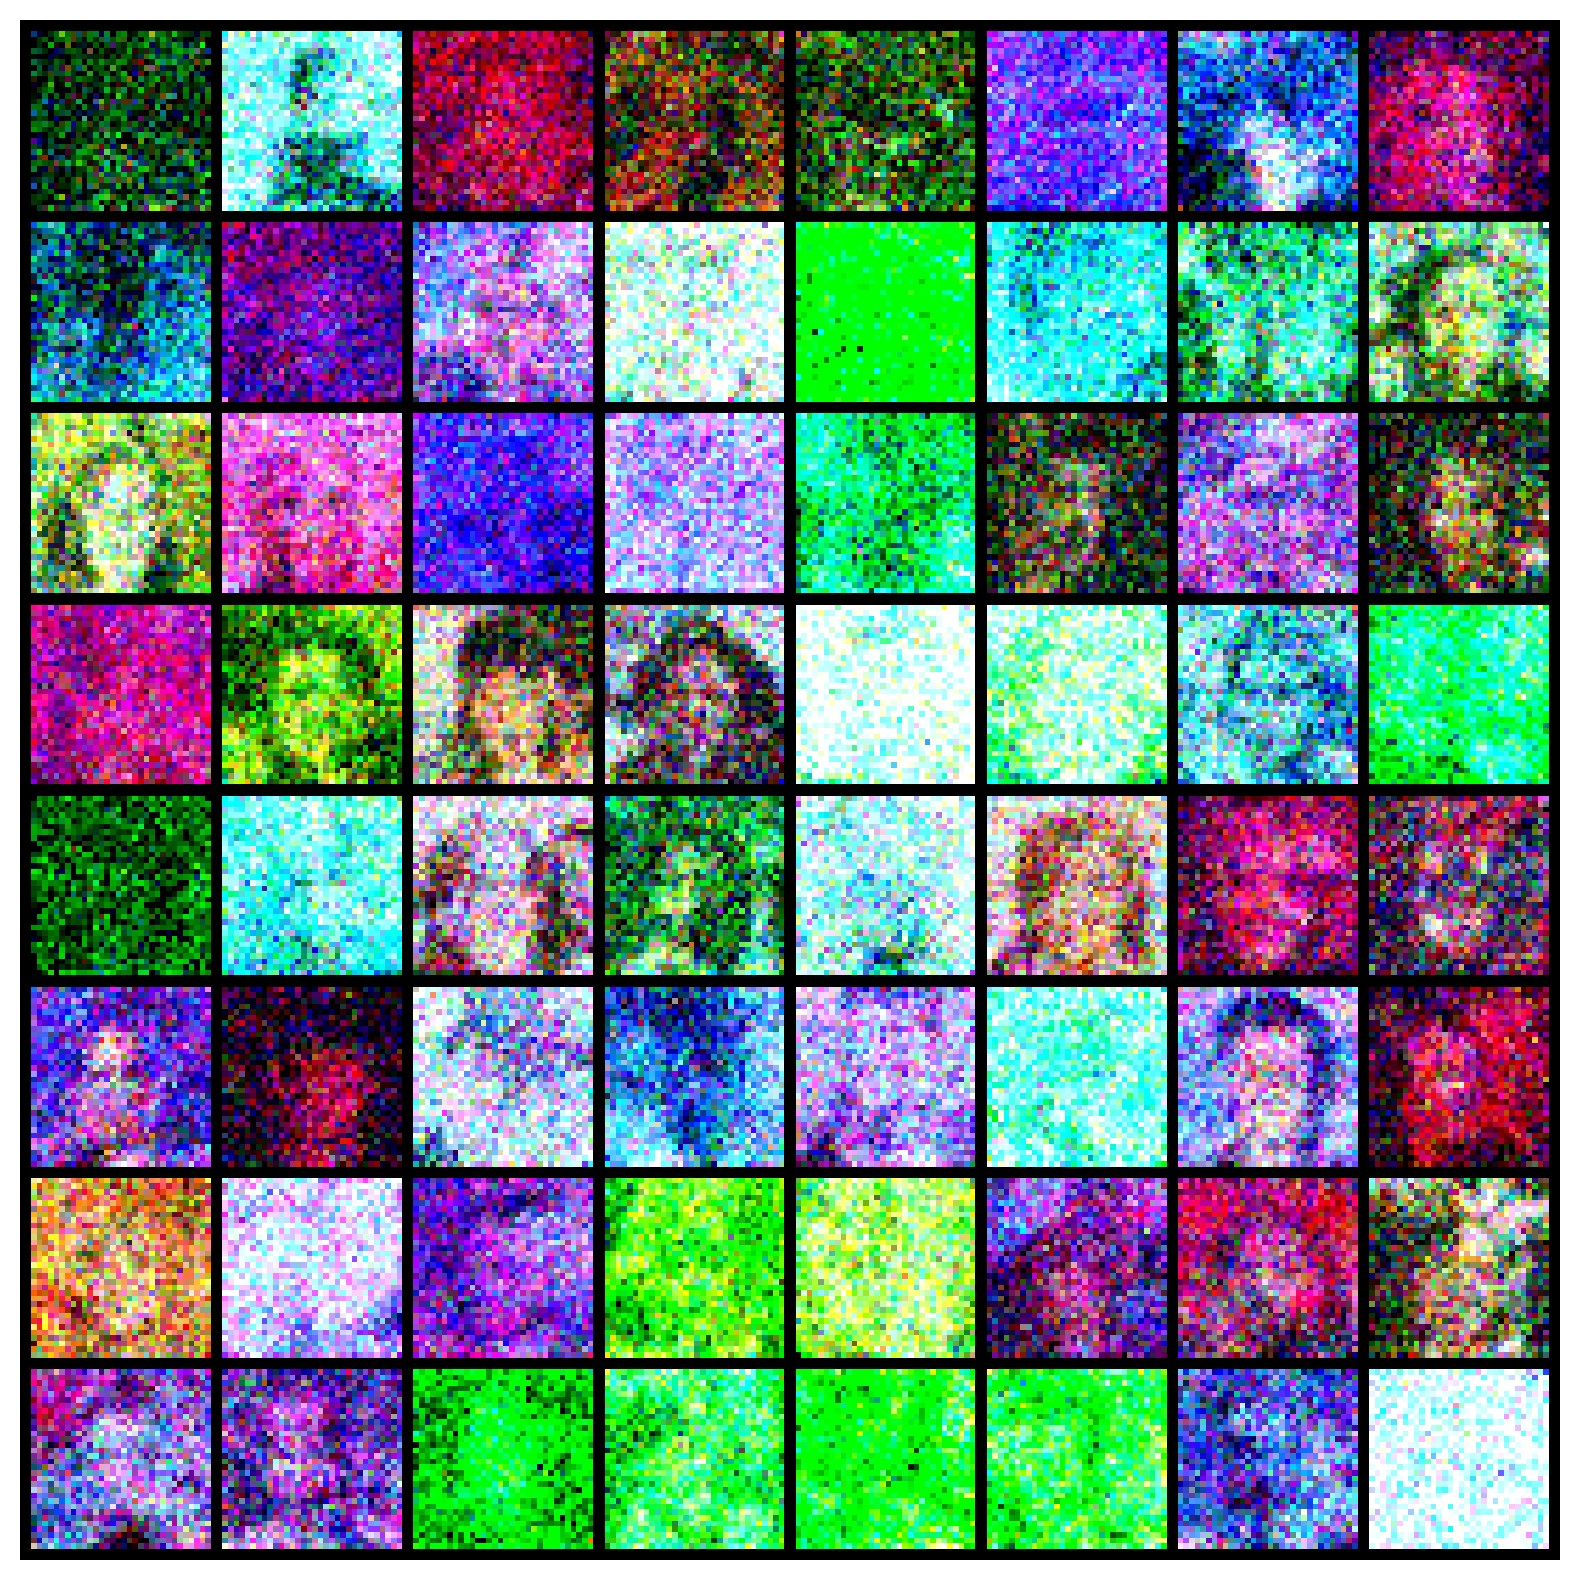

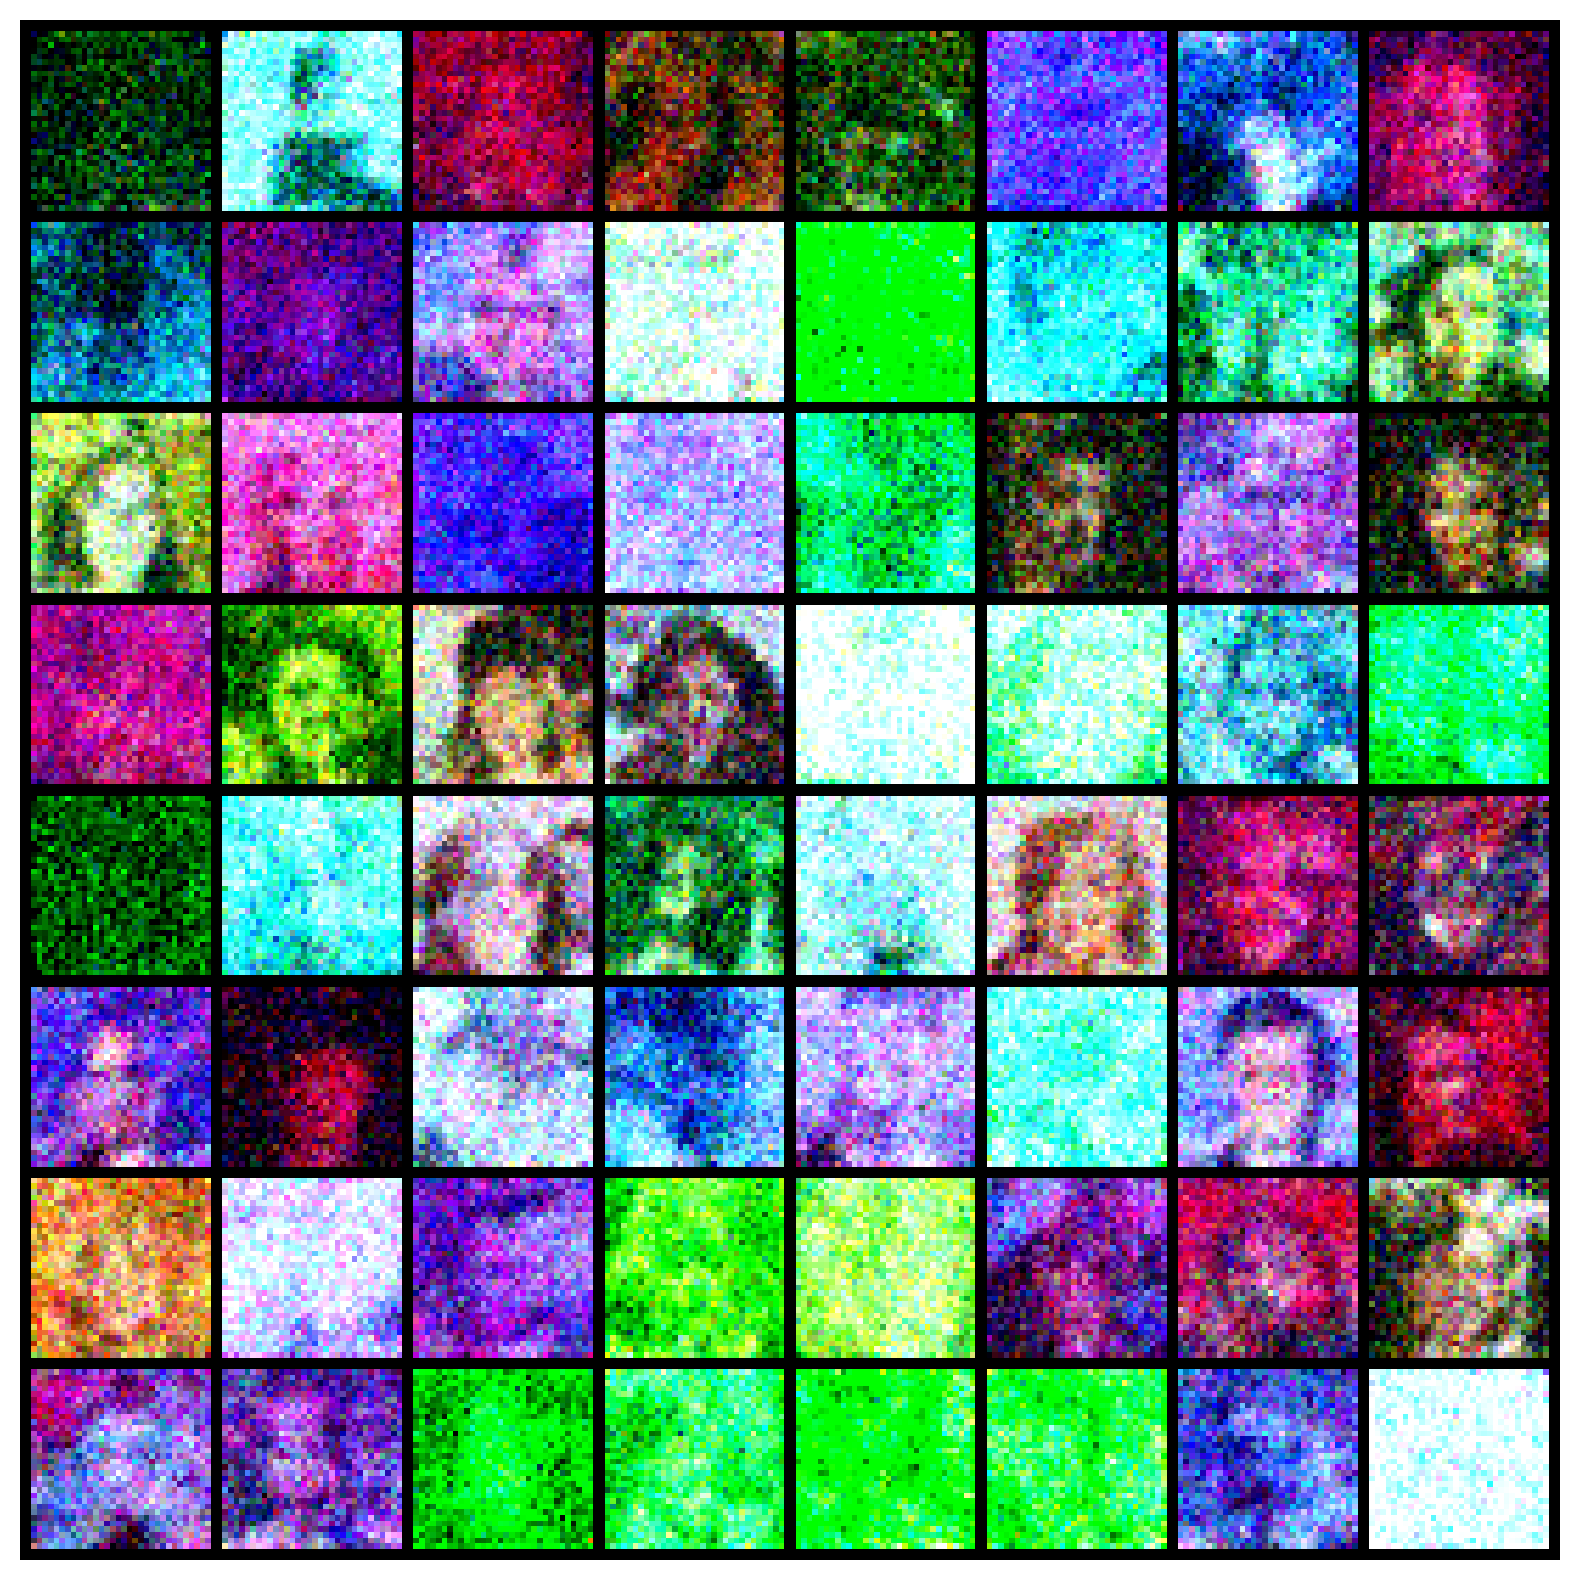

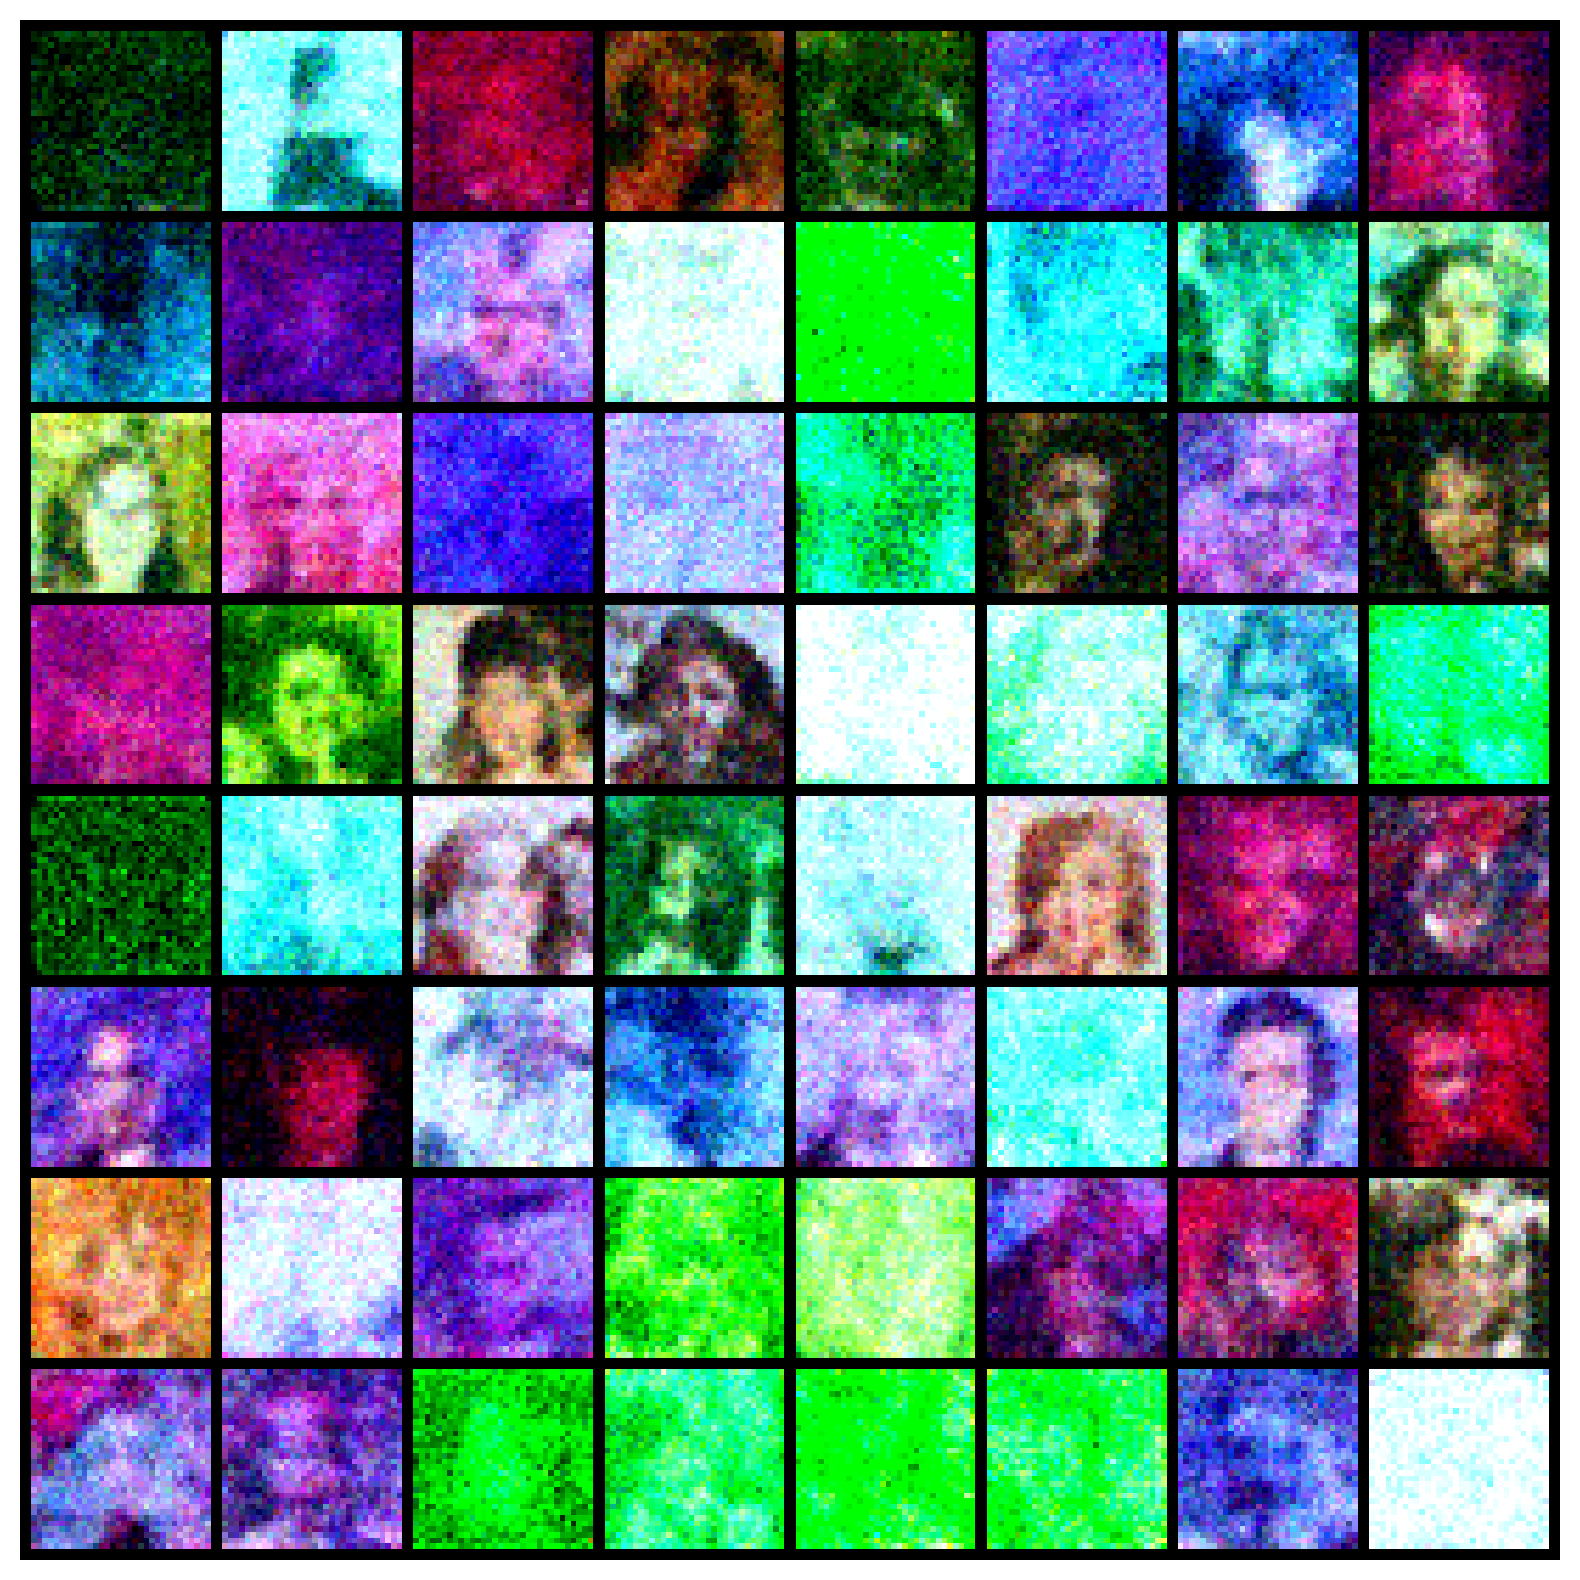

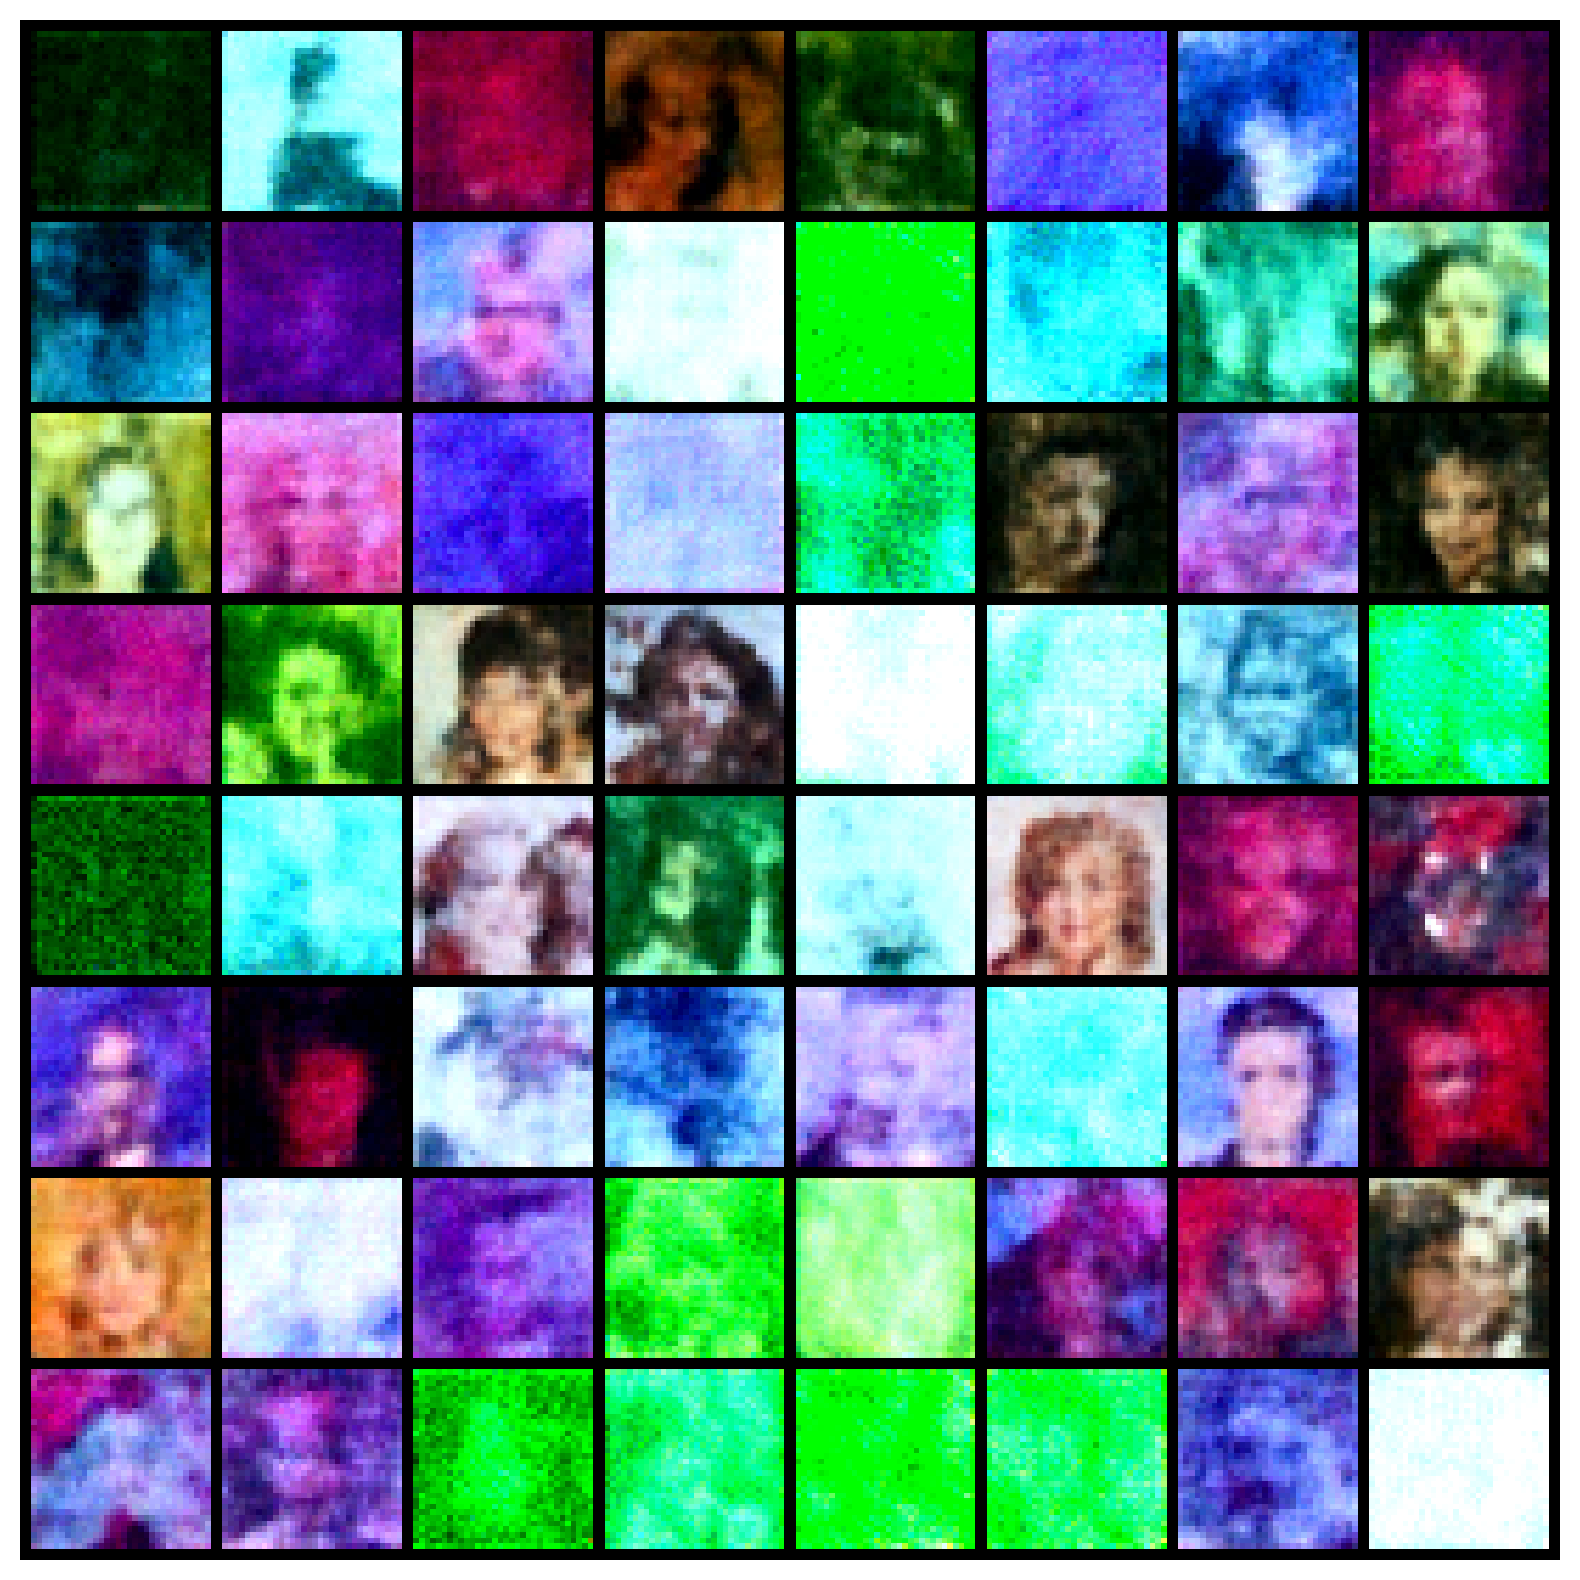

In [26]:
scheduler = LinearNoiseScheduler(T, beta_start, beta_end)

model = UNet(nc).to(device)
model.load_state_dict(torch.load("./denoiseModelCeleb.pth", map_location = device))

model.eval()

with torch.no_grad():
    xt = torch.randn((num_samples, nc, image_size, image_size)).to(device)

    for t in reversed(range(T)):
        noise_pred = model(xt, torch.as_tensor(t).unsqueeze(0).to(device))

        xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(t).to(device))

        ims = torch.clamp(xt, -1., 1.).detach().cpu()
        ims = (ims + 1) / 2
        grid = vutils.make_grid(ims, nrow = num_grid_rows)

        if (t % 50 == 0):
            plt.figure(figsize = (10, 10))
            plt.axis("off")
            # plt.title(f"t = {t}")
            plt.imshow(np.transpose(grid.cpu().detach().numpy(), (1, 2, 0)))
            plt.show()

        img = transforms.ToPILImage()(grid)
        if not os.path.exists("./DDPM/Celeb"):
            os.makedirs("./DDPM/Celeb")

        img.save(f"./DDPM/Celeb/x0_{t}.png")
        img.close()

In [ ]:
!zip -r ./Samples.zip ./Samples/